<a href="https://colab.research.google.com/github/peruvianox/kT-Fp-MetCost/blob/main/KtFpMetCost.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import Statistical Libraries

(SPM1D and Pingouin)

In [1]:
pip install spm1d

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 8.5 MB 5.4 MB/s 


In [2]:
pip install pingouin

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 185 kB 5.1 MB/s 
     |████████████████████████████████| 9.8 MB 41.3 MB/s 
  Created wheel for pingouin: filename=pingouin-0.5.2-py3-none-any.whl size=196206 sha256=e2547611e770d898a3bdee22a8bba51d773c23254f3dcb80a27643cf1d3bc8f9
  Stored in directory: /root/.cache/pip/wheels/11/5a/63/a6d32fc26fa462c731f65480bfb98ff7bd39b8ebcb4bc6c2fe
  Created wheel for littleutils: filename=littleutils-0.2.2-py3-none-any.whl size=7048 sha256=ba0f1a5ac6709ca6490b261c00bc214b8cdacad483ba0f2e8029755964348f8f
  Stored in directory: /root/.cache/pip/wheels/d6/64/cd/32819b511a488e4993f2fab909a95330289c3f4e0f6ef4676d
Successfully built pingouin littleutils
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.12.2
    Uninstalling statsmodels-0.12.2:
      Successfully uninstalled statsmodels-0.12.2


## Load Data and Packages

In [3]:
import os
import xml.etree.ElementTree as ET
from google.colab import drive
drive.mount("/content/drive")
DataFolder = '/content/drive/My Drive/ktFpMetCost/'
os.chdir(DataFolder)

import matplotlib.pyplot as plt
import pandas as pd   
import fnmatch
import spm1d
from scipy.io import loadmat 
from scipy import interpolate
from scipy import signal
import numpy as np
from matplotlib.patches import Rectangle

MetCost = pd.read_csv(DataFolder + 'MetCosts.csv')
# MetCost = pd.read_csv(DataFolder + 'MetCosts.csv')
plt.close('all')

Mounted at /content/drive


In [4]:
# simplify muscles with multiple lines of action
MetCostSimp = MetCost.reset_index(drop=True).drop(columns='Unnamed: 0')
UniMuscCols = np.unique(MetCost['Muscles'])
SubjList = np.unique(MetCost['Subj'])

conditions = ['Fm40', 'Fm20', 'NormF', 'Fp20', 'Fp40']
StrnLvls = ['0.02', '0.033','0.04','0.06','0.08']
RelConds = ['-40', '-20', 'Norm', '+20', '+40']
StrnLvl = [2, 3, 4, 6, 8]

Musc2Simp = ['add_mag', 'glut_max','glut_med','glut_min']

for S in SubjList:

  SubjInds = [x for x, z in enumerate(MetCost['Subj'].tolist()) if z == S]

  for m in Musc2Simp:
 
    MuscInds = [x for x, z in enumerate(MetCost['Muscles'].tolist()) if m in z]
    
    for C in conditions:
        CondInds = [x for x, z in enumerate(MetCost['Cond'].tolist()) if z == C]
        j = 0
        for strn in StrnLvl:
            # identify trials that match desired conditions
            StrnInds = [x for x, z in enumerate(MetCost['StrnLvl'].tolist()) if z == strn]
            match = list(set(MuscInds) & set(CondInds) & set(StrnInds) & set(SubjInds))
            match.sort()
            
            # sum values from invidual muscle lines of action
            Sum = np.sum(MetCostSimp.iloc[match, 4:], axis=0)
            MetCostSimp.iloc[match[0], 3] = m
            MetCostSimp.iloc[match[0], 4:] = Sum
            MetCostSimp.iloc[match[0]]       

Musc2Drop = []
for i, x in enumerate(MetCostSimp['Muscles']):
  if '2' in x:
    Musc2Drop.append(i)
  elif '3' in x:
    Musc2Drop.append(i)

MetCostSimp = MetCostSimp.drop(index=Musc2Drop).reset_index(drop=True)
MetCostSimp.to_csv(DataFolder + 'MetCostSimp.csv')
MetCost = MetCostSimp

## Plot Average Heat Maps

In [14]:
# define function to plot average heat maps
# heat map of total average met costs
plt.close('all')
fnt=24
import matplotlib.colors as mcolors
import pingouin as pg
conditions = ['Fm40', 'Fm20', 'NormF', 'Fp20', 'Fp40']
StrnLvls = ['0.02', '0.033','0.04','0.06','0.08']
plt.rcParams.update({'font.size': fnt})

def MakeHeatMap(musc):
    
  plt.figure(figsize=(12, 12))
  RelConds = ['-40', '-20', 'Norm', '+20', '+40']
  StrnLvl = [2, 3, 4, 6, 8]
  i = 0
  k = 1
  Map = np.zeros((5,5))
  Amap = np.empty((5,5), dtype=object)
  MuscInds = [x for x, z in enumerate(MetCost['Muscles'].tolist()) if z == musc]
    
  for C in conditions:
      CondInds = [x for x, z in enumerate(MetCost['Cond'].tolist()) if z == C]
      j = 0
      for strn in StrnLvl:
          # identify trials that match desired conditions
          StrnInds = [x for x, z in enumerate(MetCost['StrnLvl'].tolist()) if z == strn]
          match = list(set(MuscInds) & set(CondInds) & set(StrnInds))
          match.sort()
          
          # create 2D array of average values
          Y = np.array(MetCost.iloc[match, 4:])
          Amap[i, j] = Y.mean(axis=1) 
          Map[i, j] = Y.mean()
          
          j = j+1
          k = k+1
      
      i = i+1
      
  # define color normalization class
  class MidpointNormalize(mcolors.Normalize):
      def __init__(self, vmin=None, vmax=None, vcenter=None, clip=False):
          self.vcenter = vcenter
          super().__init__(vmin, vmax, clip)

      def __call__(self, value, clip=None):
          # Ignore masked values and all kinds of edge cases for a simple example...
          # top = self.vmax - self.vcenter
          # bot = self.vcenter - self.vmin
          x, y = [self.vmin, self.vcenter, self.vmax], [0, 0.5, 1]
          return np.ma.masked_array(np.interp(value, x, y))

  # normalize top and bottom of heatmap color bar
  top = np.max(Map) - Map[2,1]
  bot = Map[2,1] - np.min(Map)
  M = max([top, bot])
  # midnorm = MidpointNormalize(vmin=0, vcenter=Map[2,1], vmax=Map[2,1] + M)
  midnorm = MidpointNormalize(vmin = Map[2,1] - M, vcenter=Map[2,1], vmax=Map[2,1] + M)
  # midnorm = MidpointNormalize(vmin=np.min(Map), vcenter=Map[2,1], vmax=np.max(Map))

  c = plt.pcolormesh(Map, cmap='bwr', norm=midnorm)
  plt.colorbar(c, label='W/kg')
  # plt.colorbar(c, label='W/kg', boundaries=[np.min(Map), np.max(Map)])

  lbl = [0.5, 1.5, 2.5, 3.5, 4.5]
  plt.xticks(lbl, ['2%','3.3%','4%','6%','8%'], fontsize=fnt)
  plt.xlabel( r'$\epsilon_0$', fontsize=fnt+5)
  plt.yticks(lbl, RelConds, fontsize=fnt)
  plt.ylabel('$F_{P}$ Intensity', fontsize=fnt+5)
  plt.title(musc, fontsize=fnt+10)

  # perform repeated measures anova on heatmaps
  match = list(set(MuscInds))
  match.sort()

  A = pd.DataFrame(np.mean(MetCost.iloc[match,4:], axis=1).reset_index()[0])
  AvgMetCost = pd.concat([MetCost.iloc[match, 0:3].reset_index(), A], axis=1, 
                          ignore_index=True)

  D = AvgMetCost.iloc[:,1:5]
  D.columns = ['Subj','StrnLvl','Cond','MetCost']
  HtMapRM = pg.rm_anova(data=D, dv='MetCost', within=['Cond', 'StrnLvl'], subject='Subj', detailed=True, effsize='np2')
  
  plt.savefig('AvgHeatMaps/' + musc+'_MetCost.pdf')
  plt.savefig('AvgHeatMaps/' + musc+'_MetCost.png')
  return Map, Amap, HtMapRM

/usr/local/lib/python3.7/dist-packages/pingouin/distribution.py:487: UserWarning: Epsilon values might be innaccurate in two-way repeated measures design where each  factor has more than 2 levels. Please  double-check your results.
  "Epsilon values might be innaccurate in "
/usr/local/lib/python3.7/dist-packages/pingouin/distribution.py:487: UserWarning: Epsilon values might be innaccurate in two-way repeated measures design where each  factor has more than 2 levels. Please  double-check your results.
  "Epsilon values might be innaccurate in "
/usr/local/lib/python3.7/dist-packages/pingouin/distribution.py:487: UserWarning: Epsilon values might be innaccurate in two-way repeated measures design where each  factor has more than 2 levels. Please  double-check your results.
  "Epsilon values might be innaccurate in "
/usr/local/lib/python3.7/dist-packages/pingouin/distribution.py:487: UserWarning: Epsilon values might be innaccurate in two-way repeated measures design where each  factor

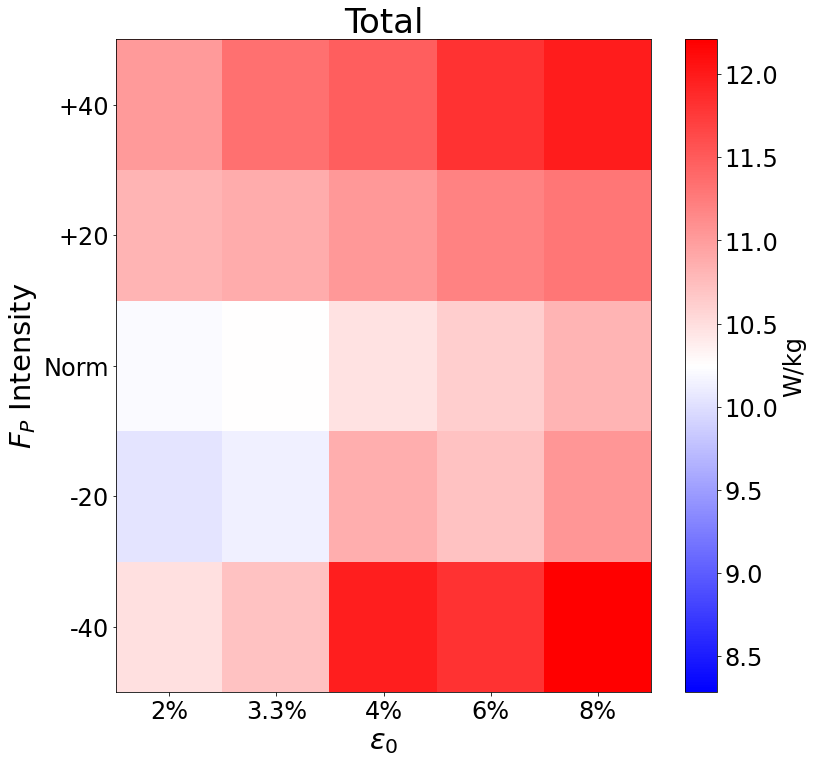

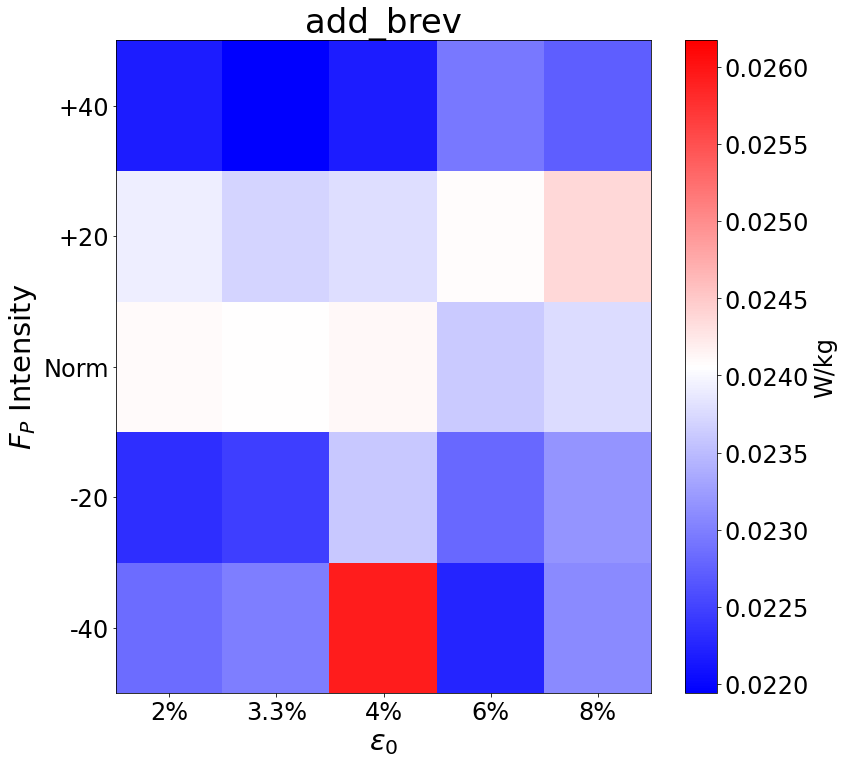

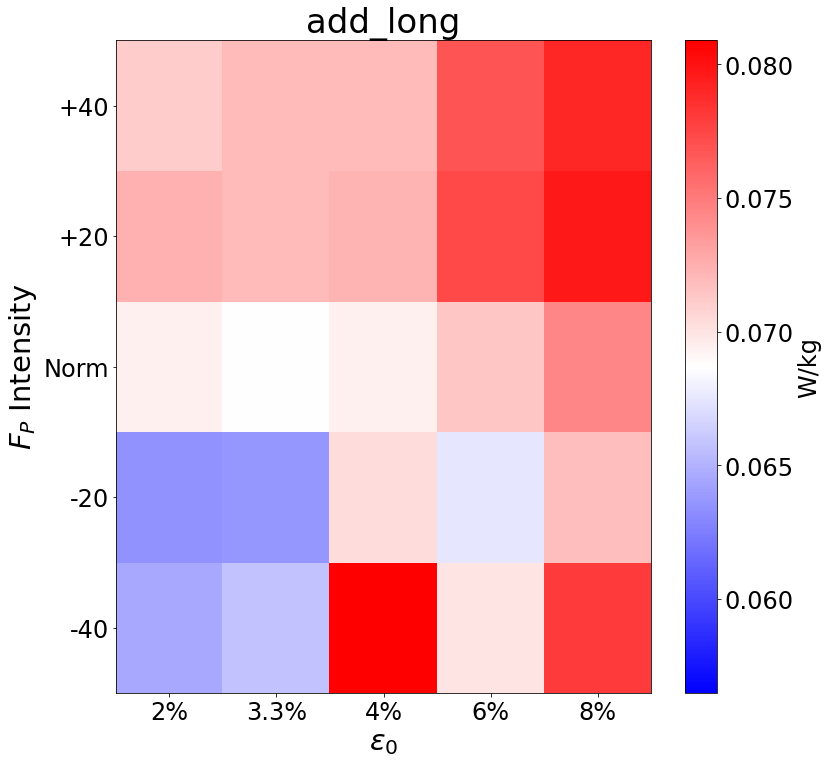

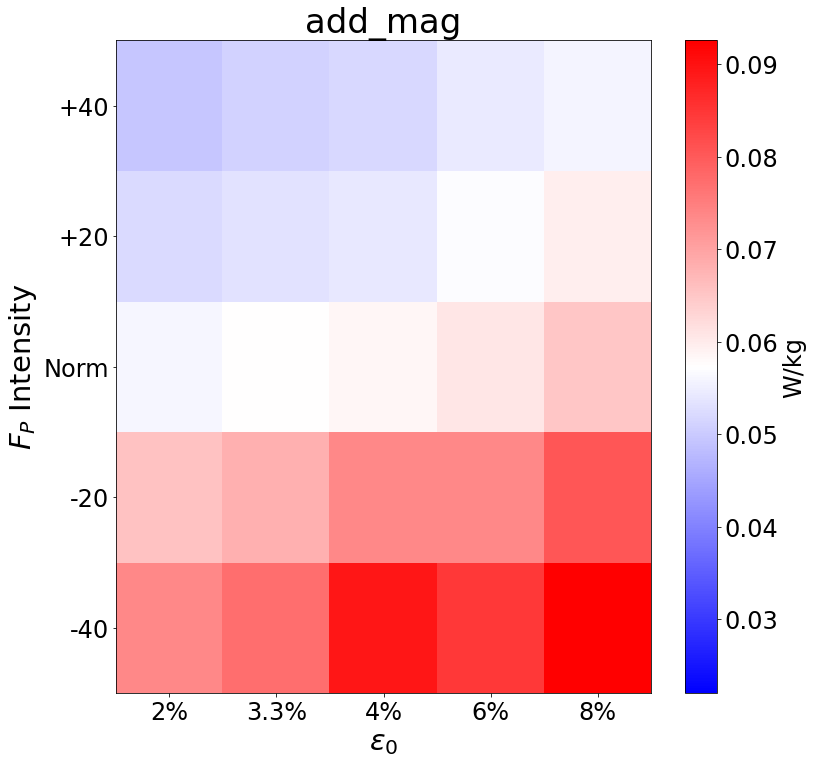

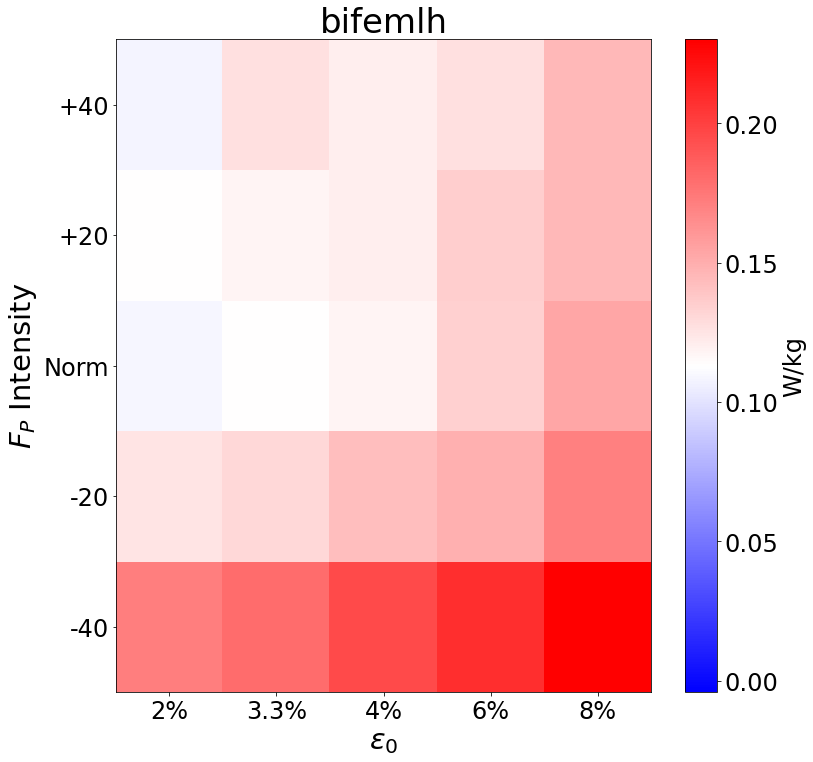

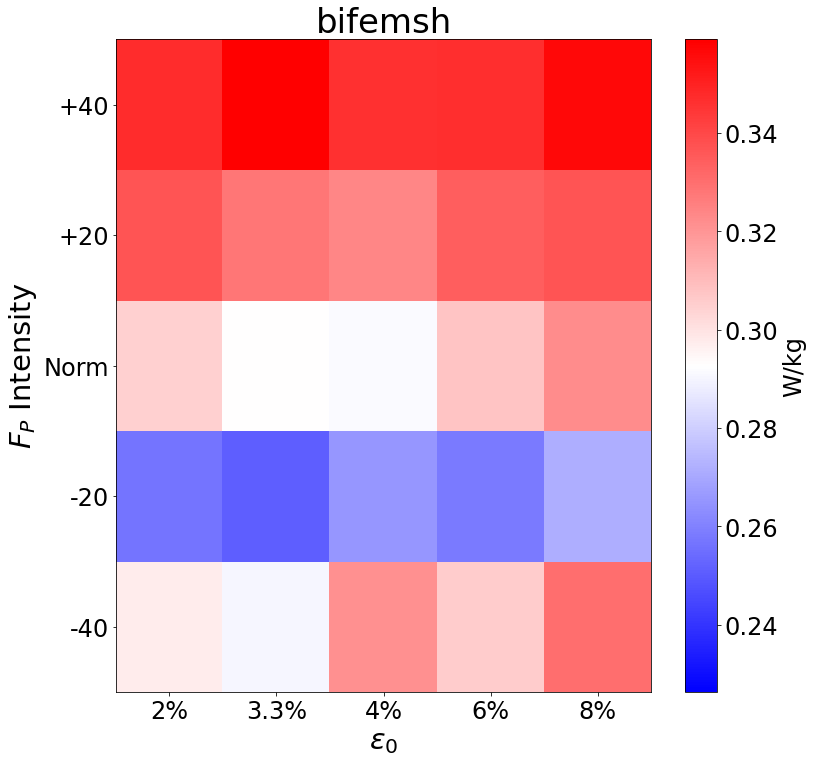

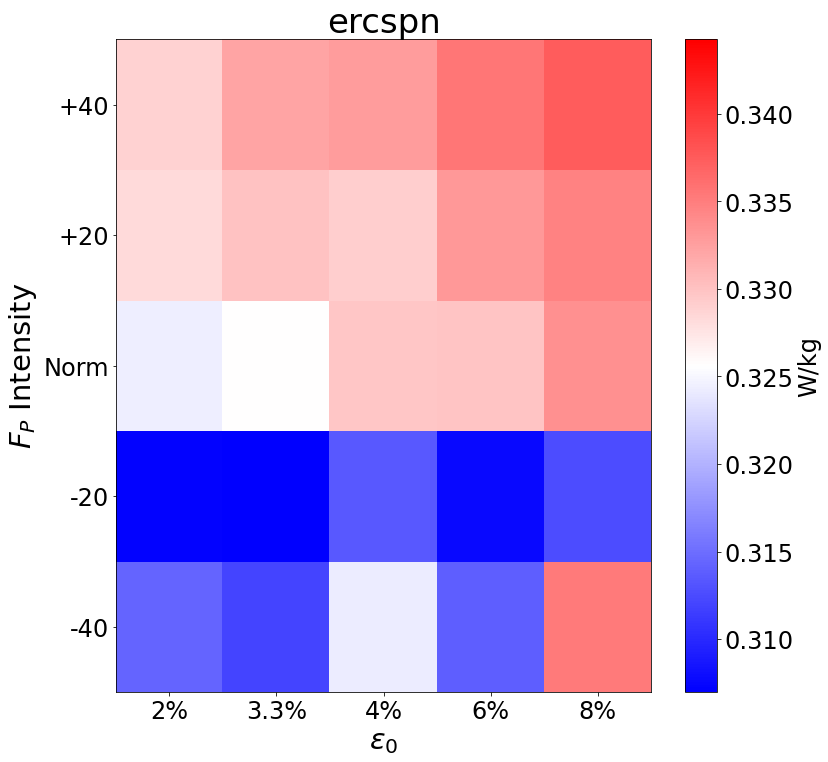

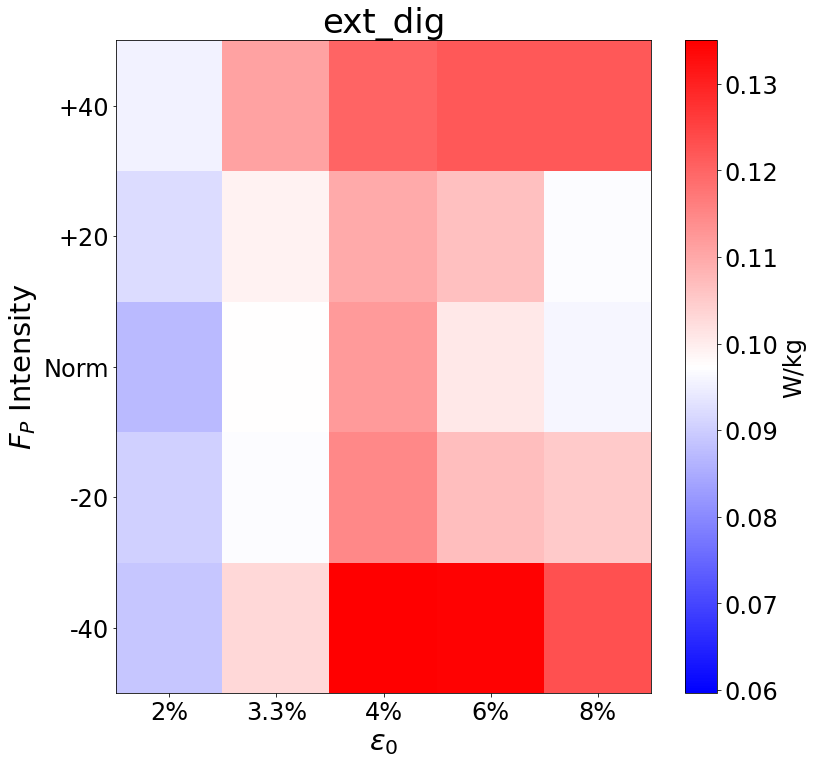

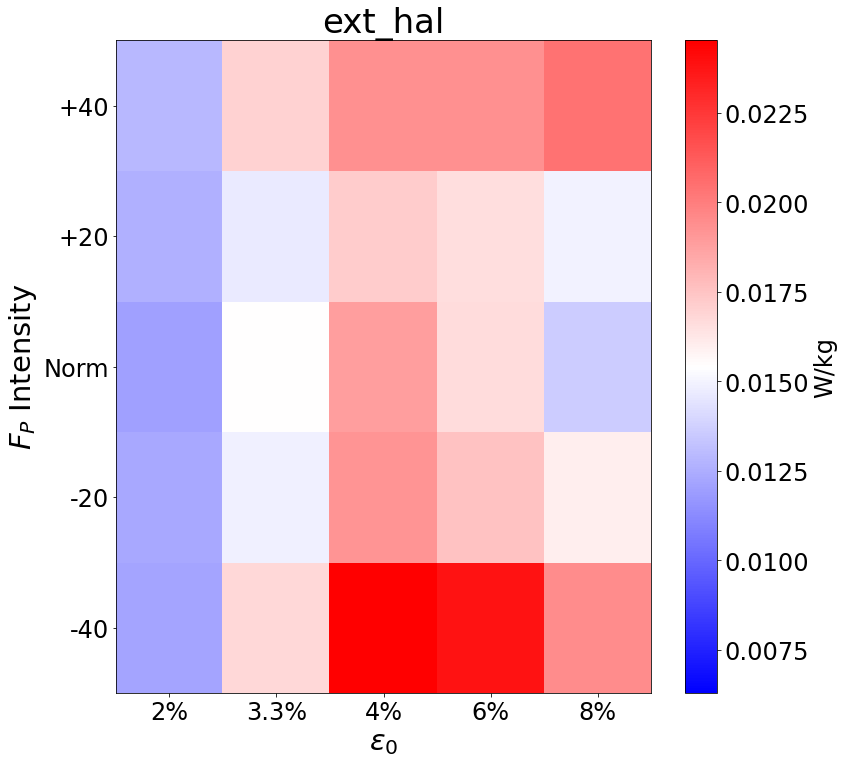

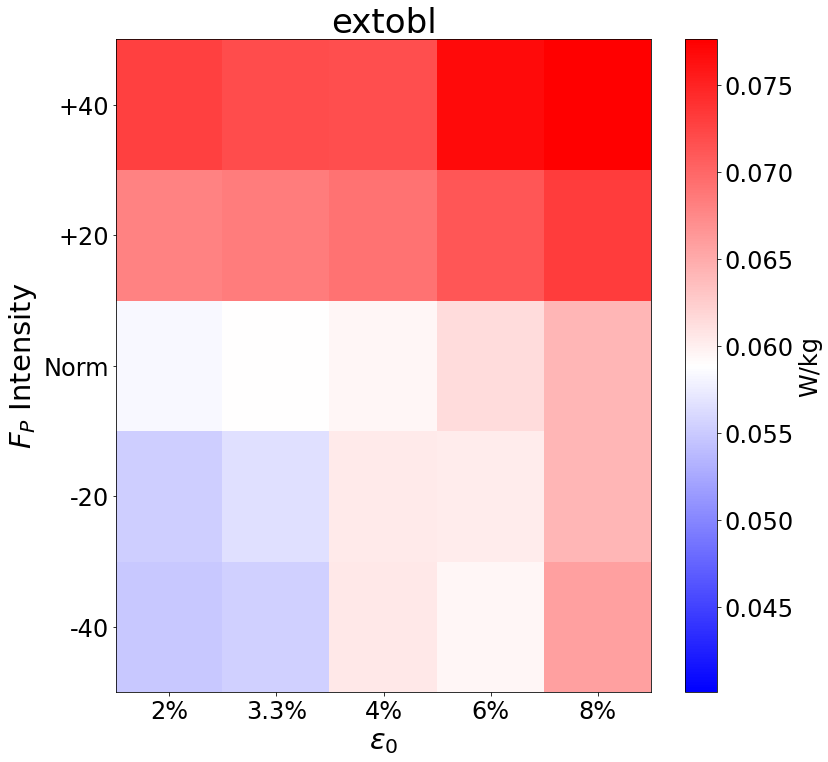

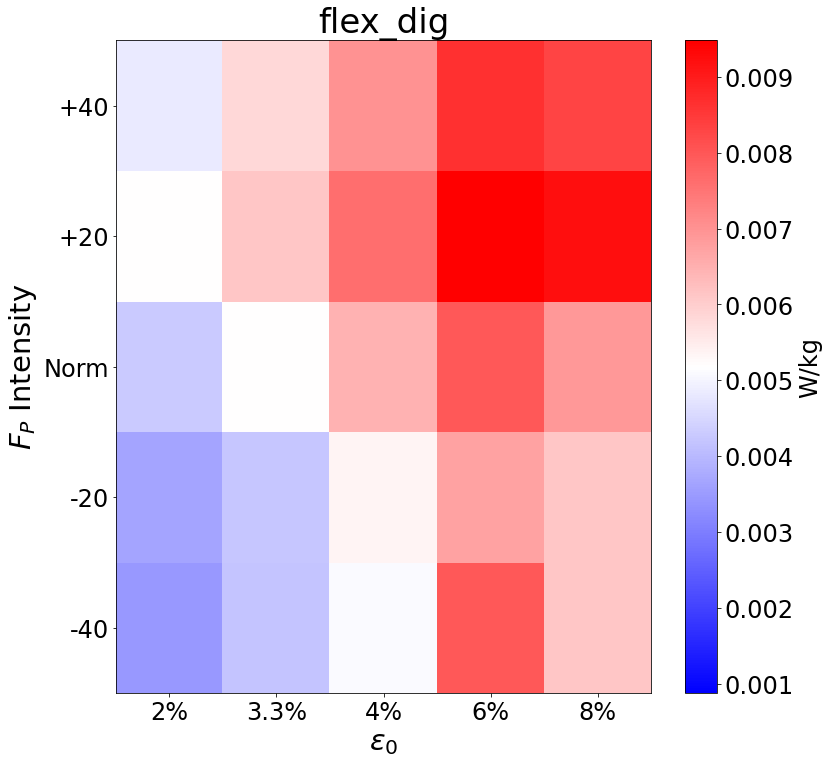

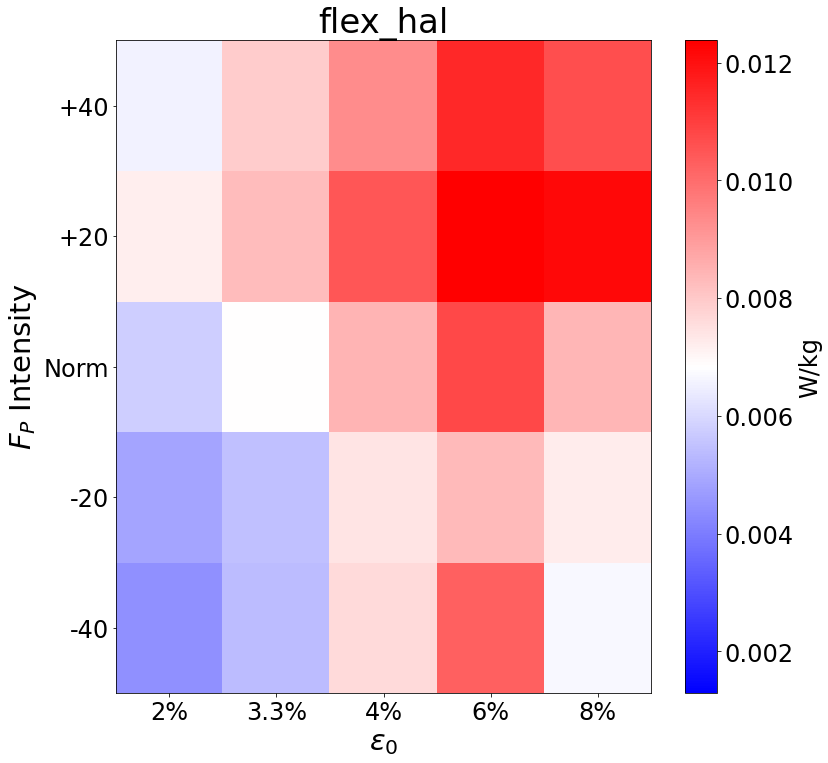

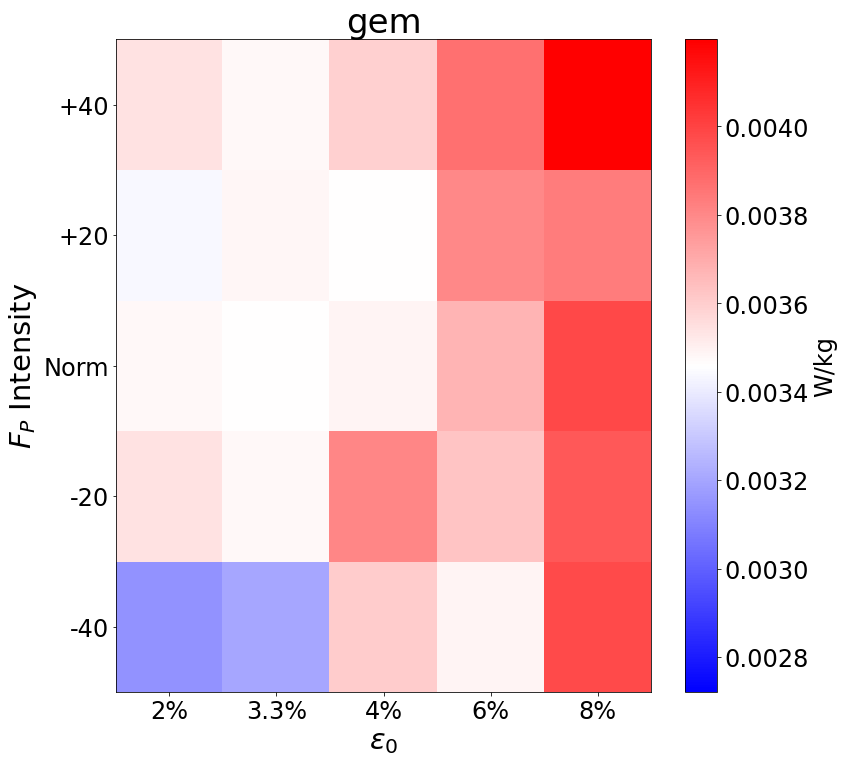

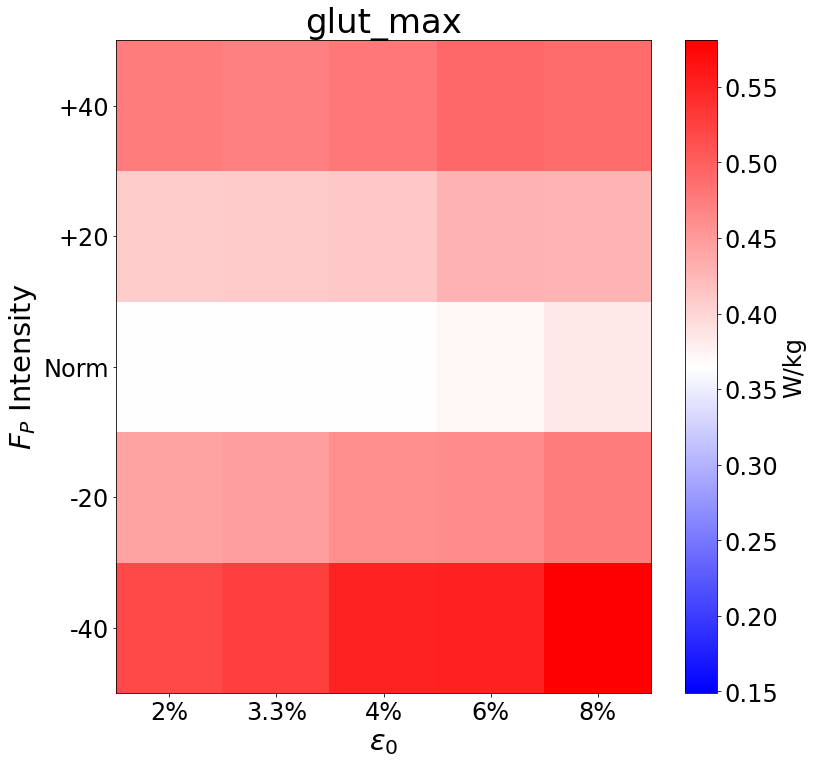

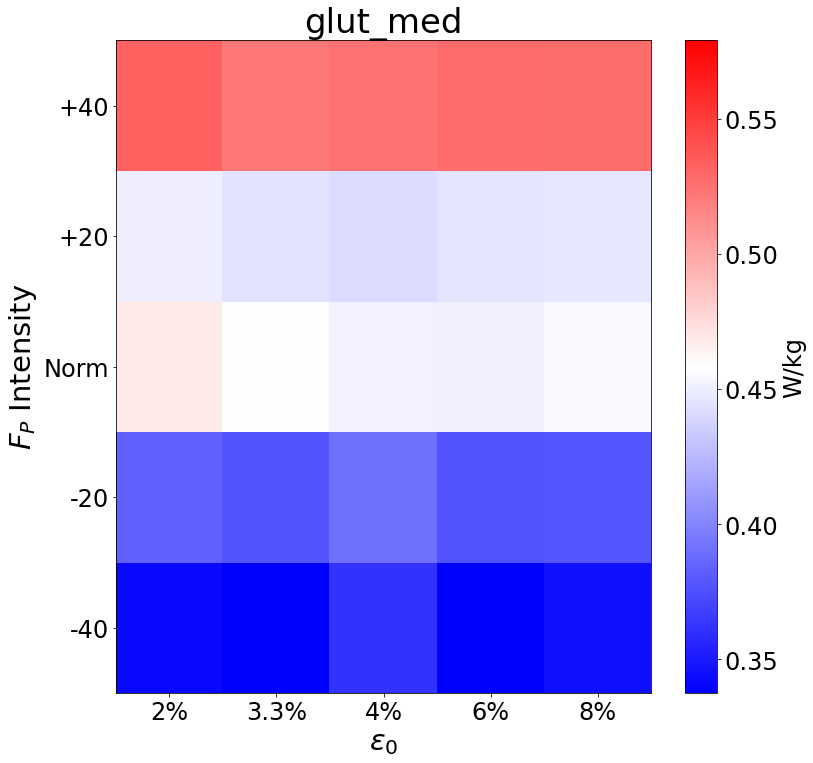

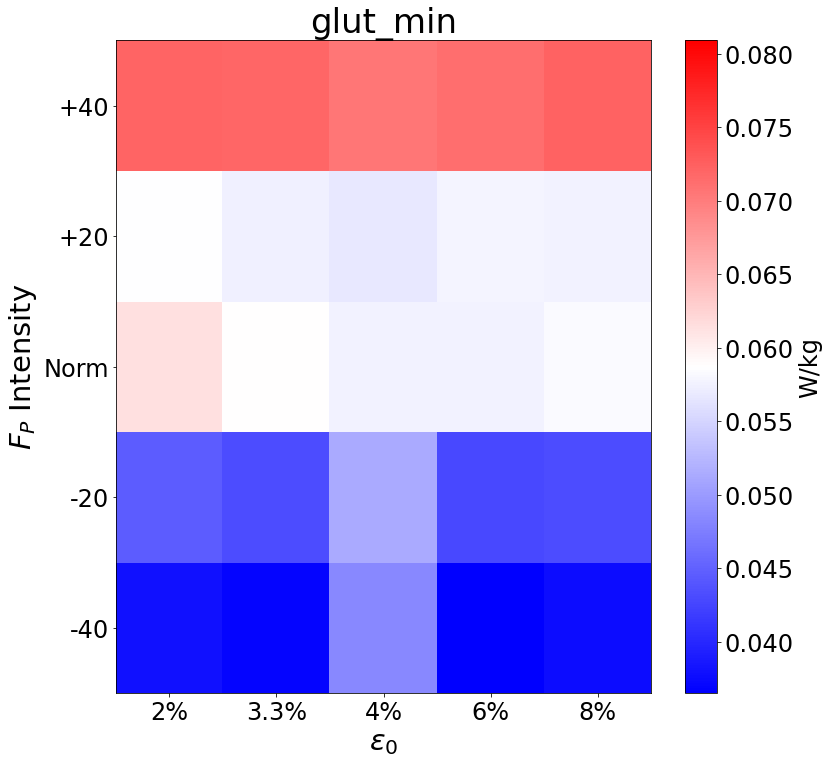

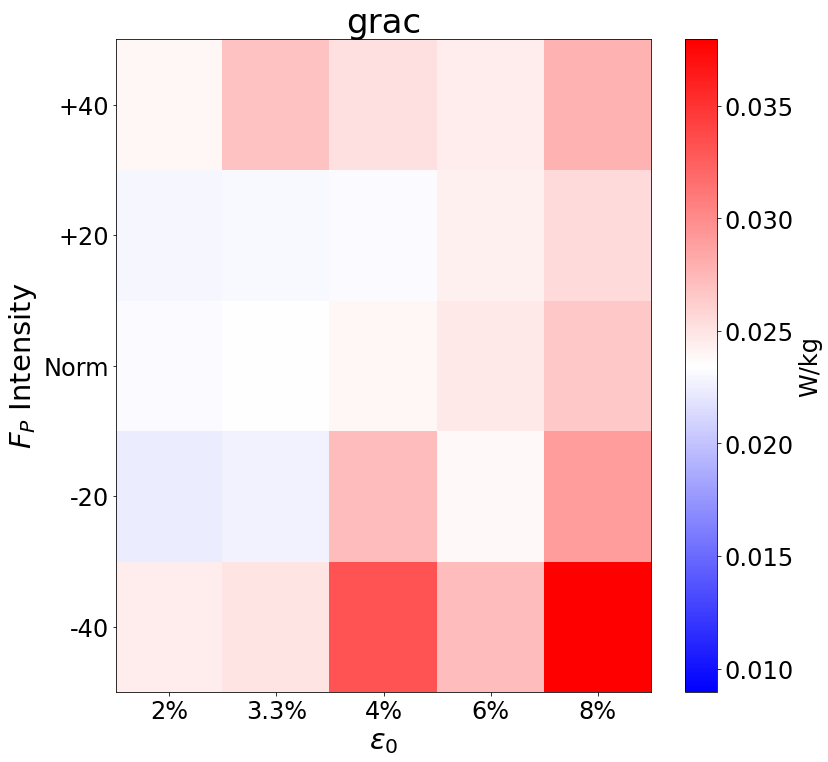

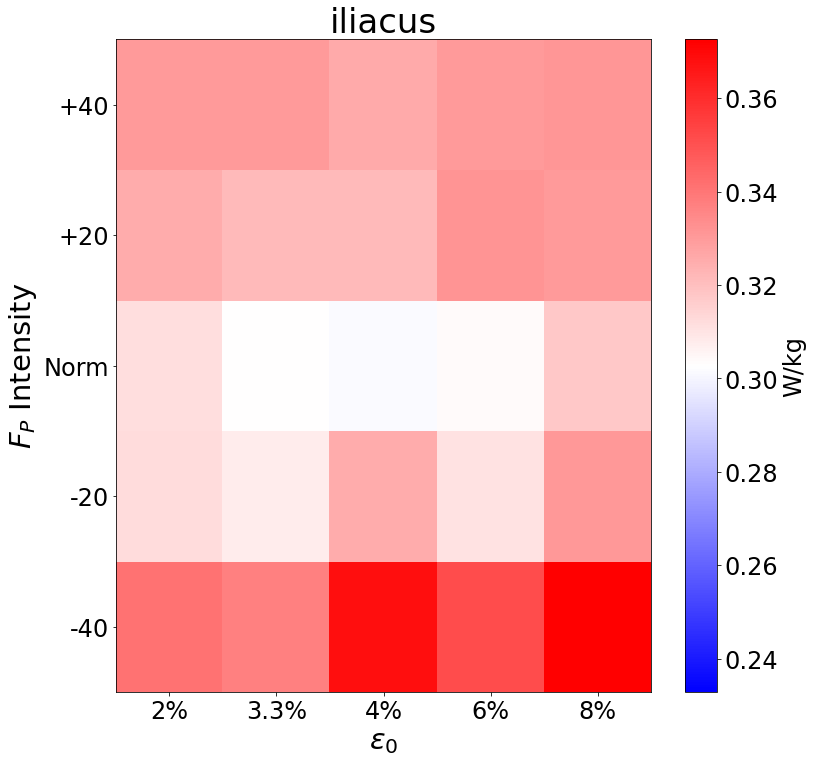

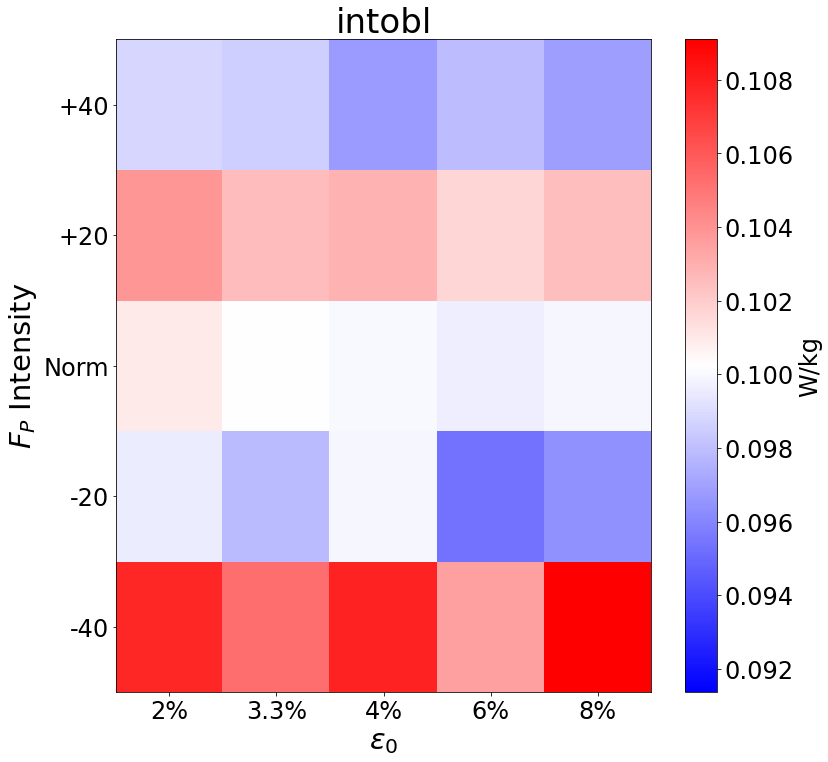

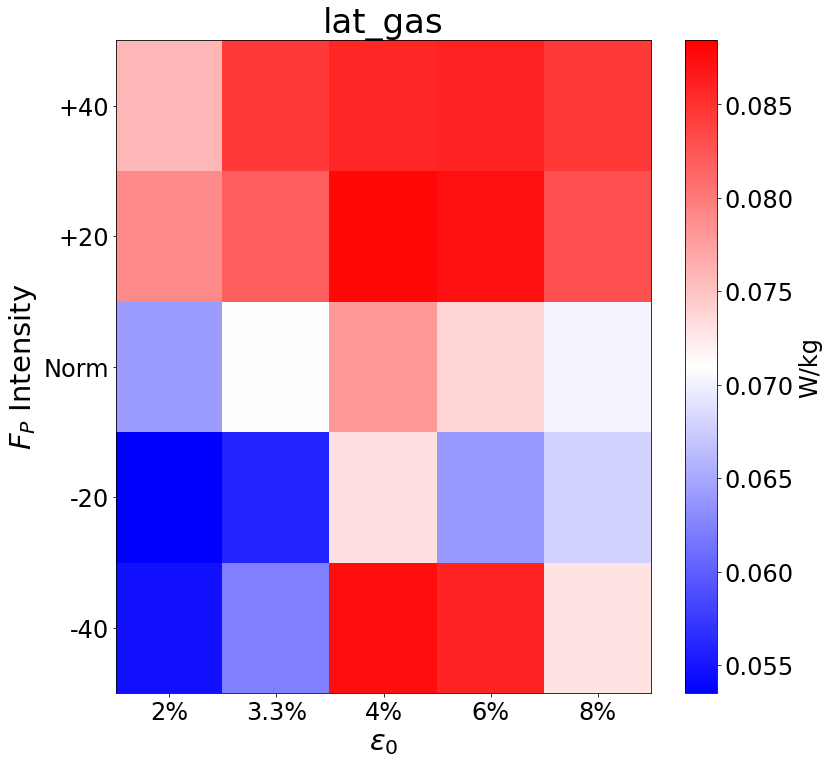

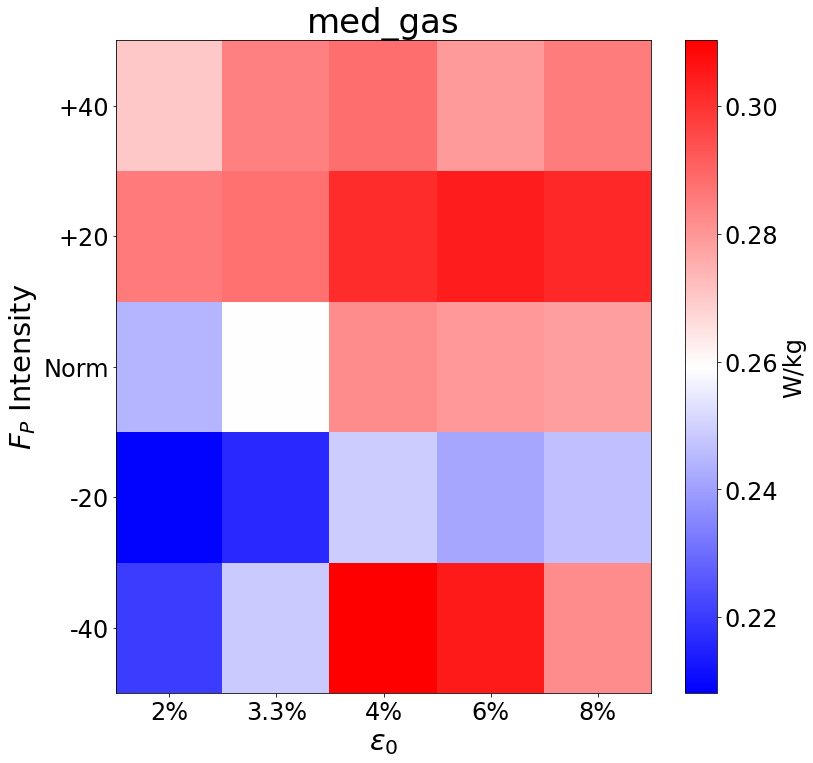

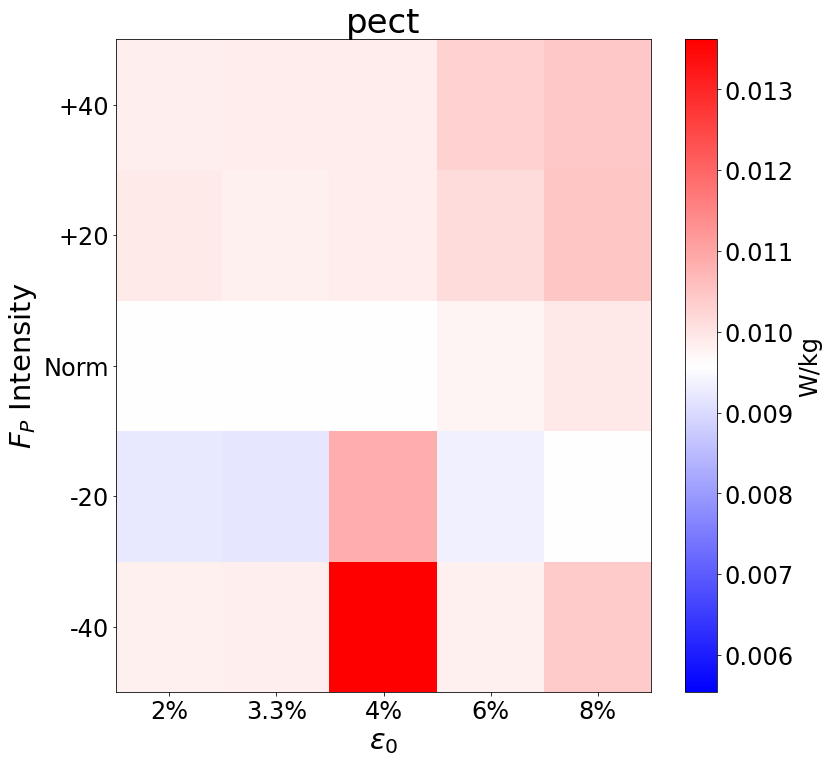

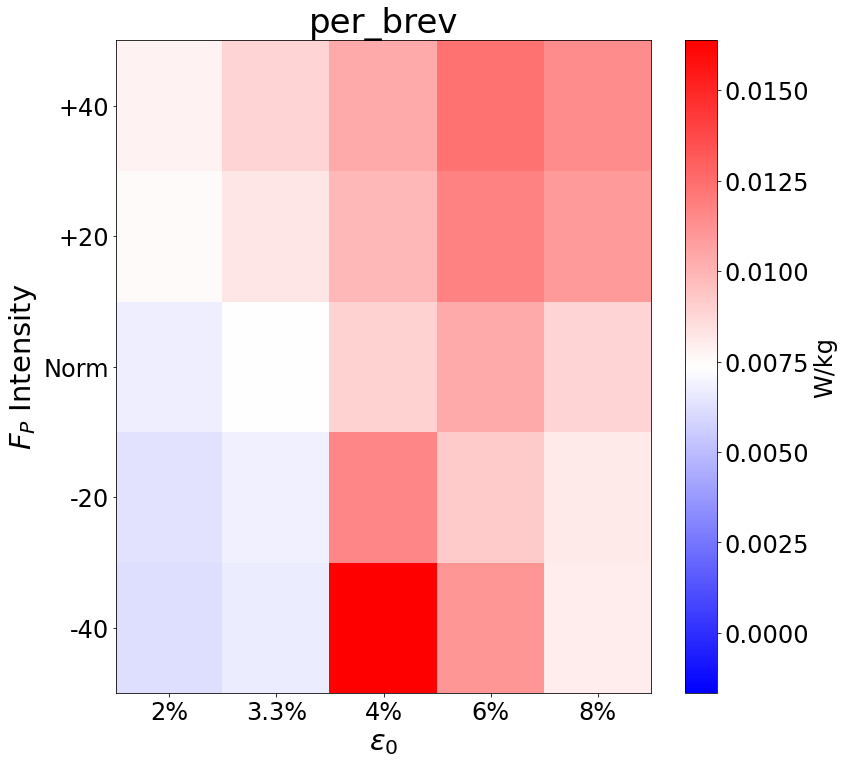

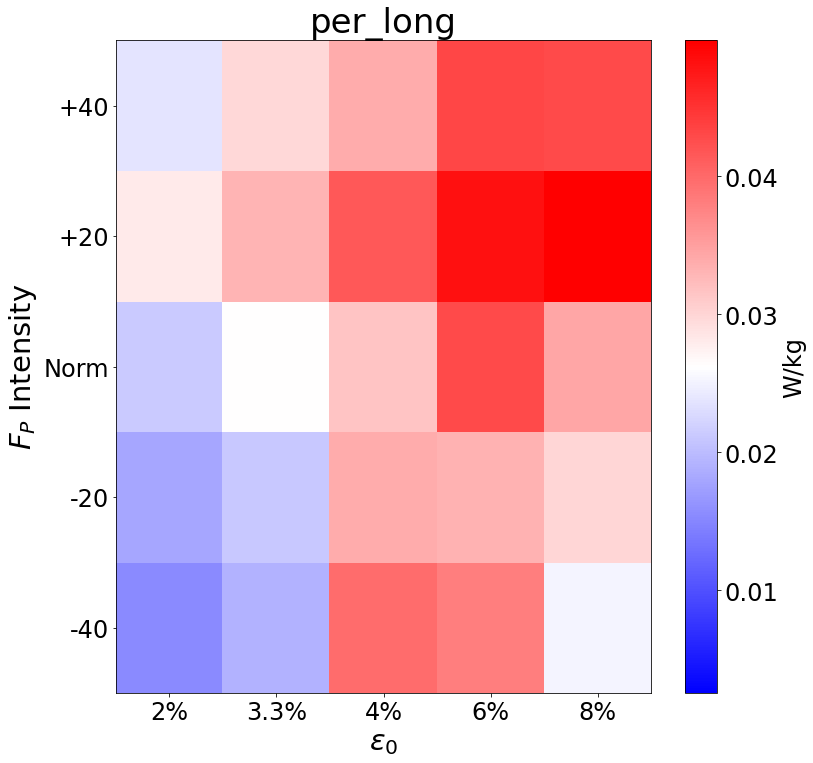

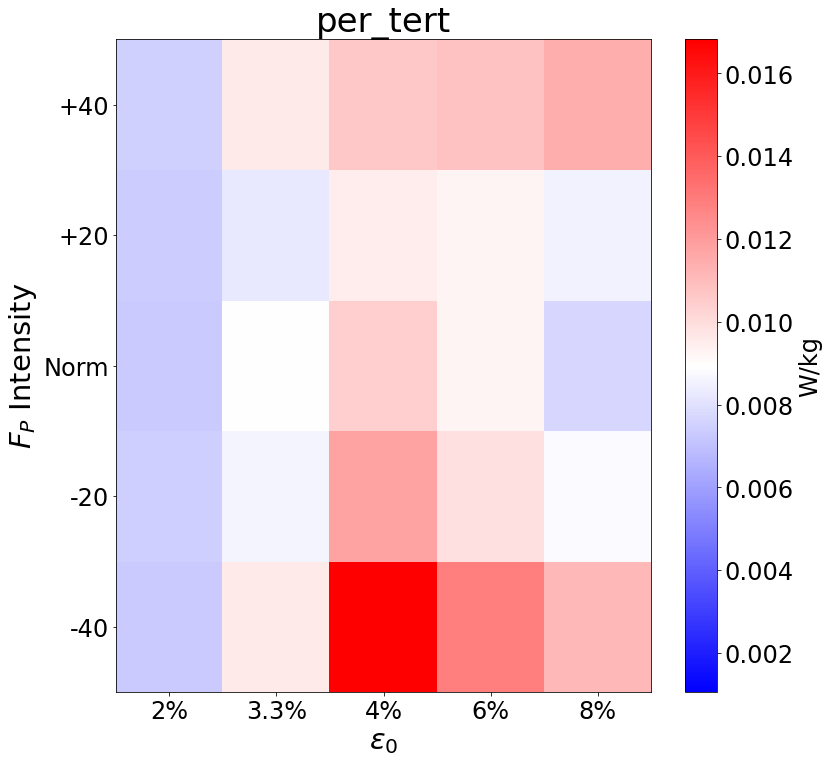

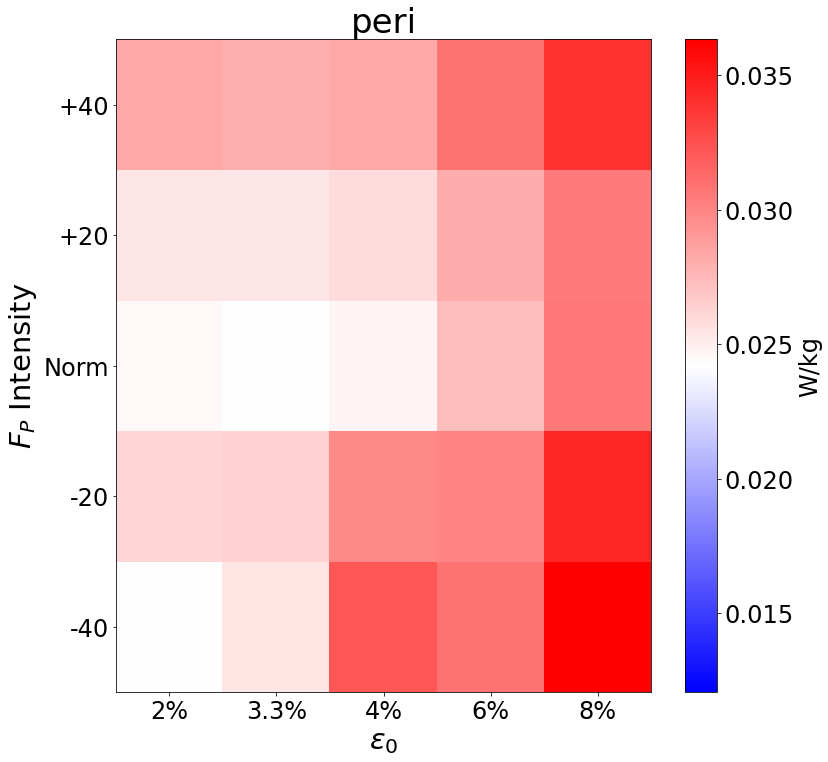

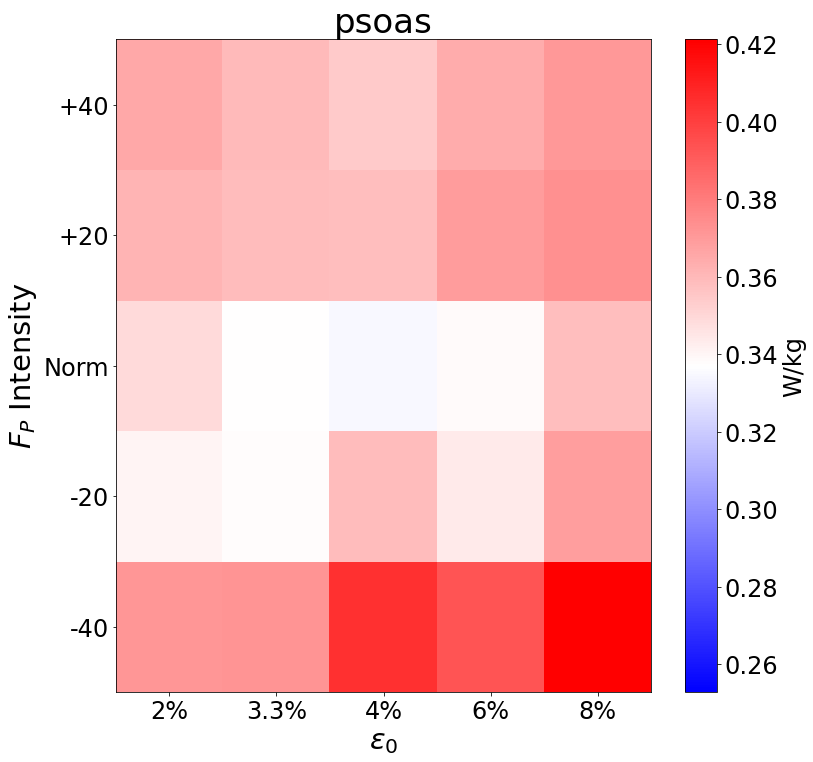

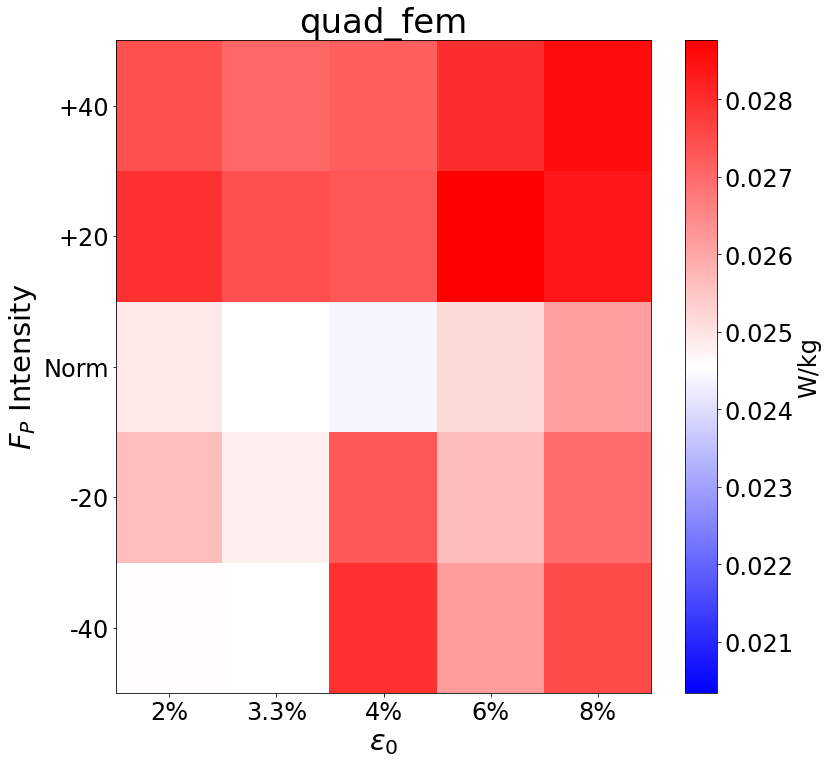

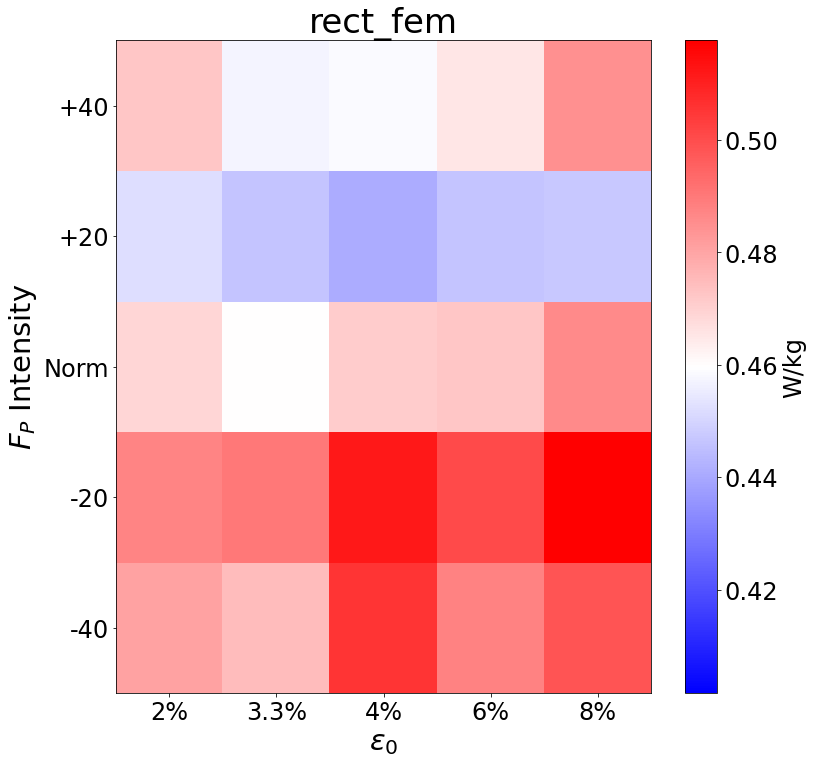

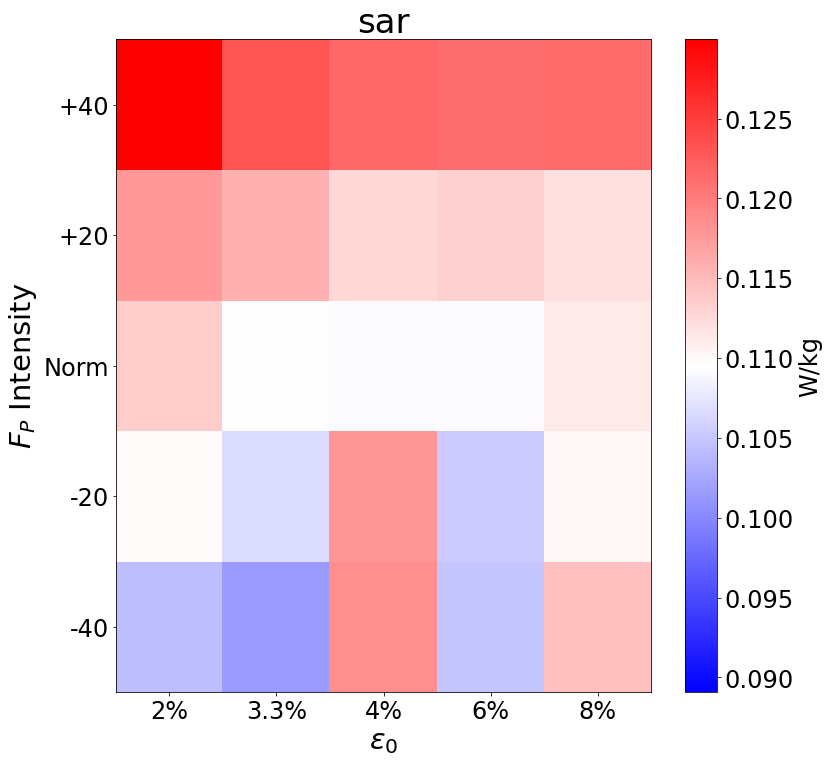

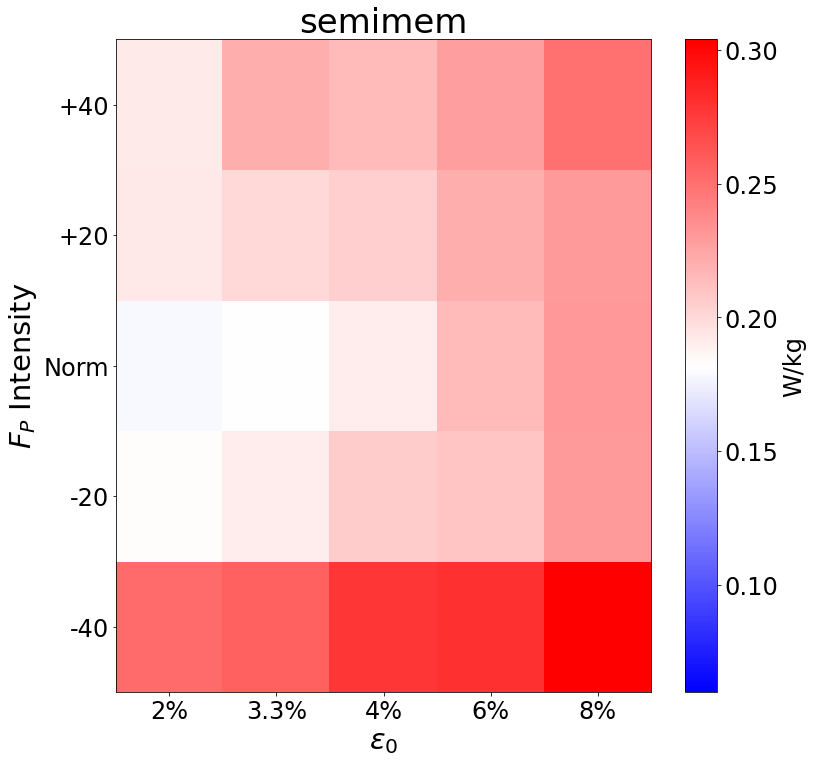

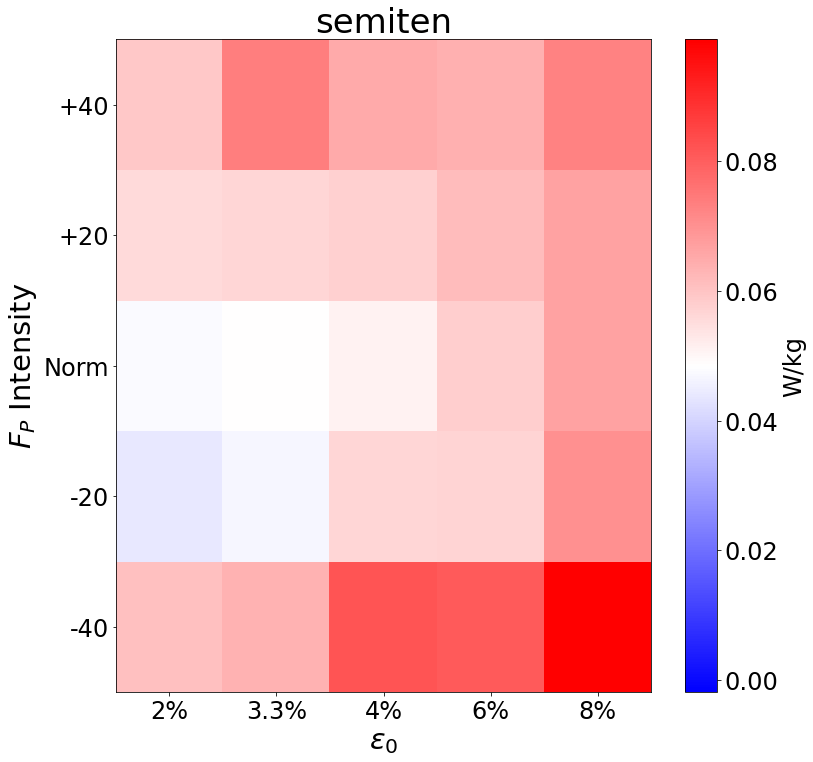

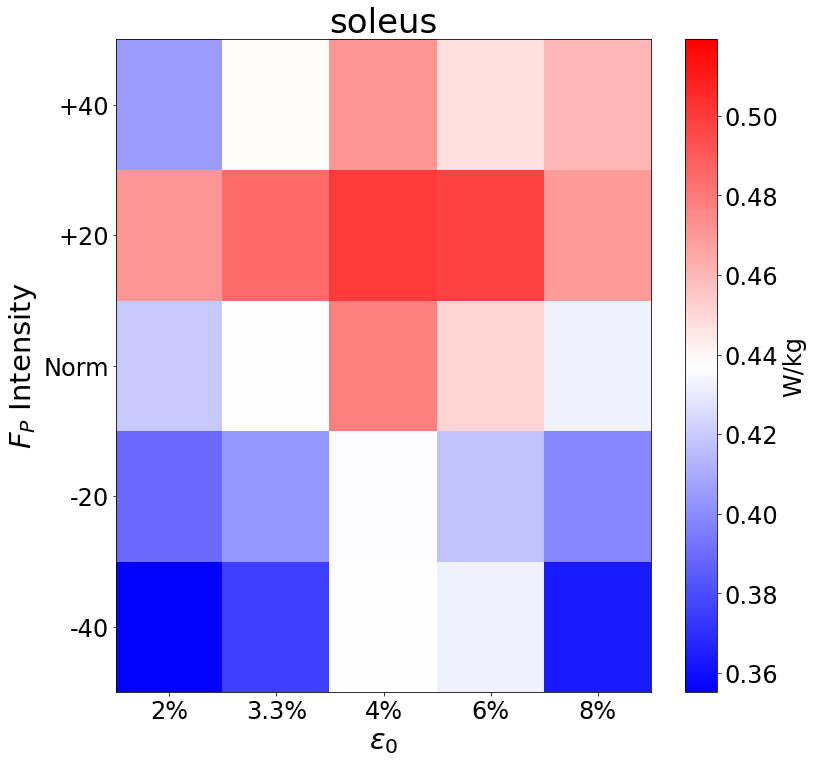

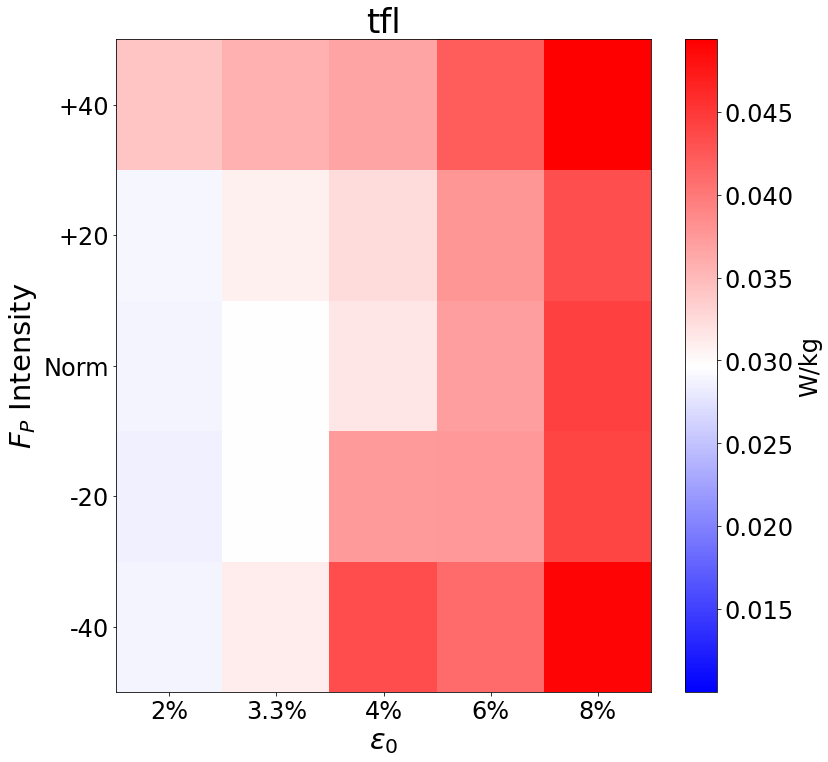

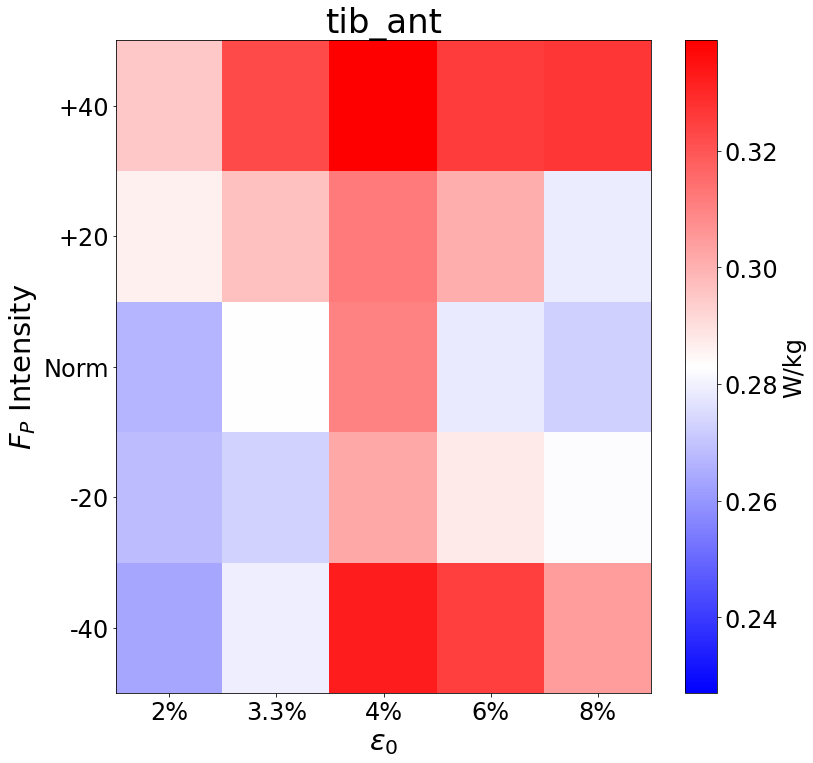

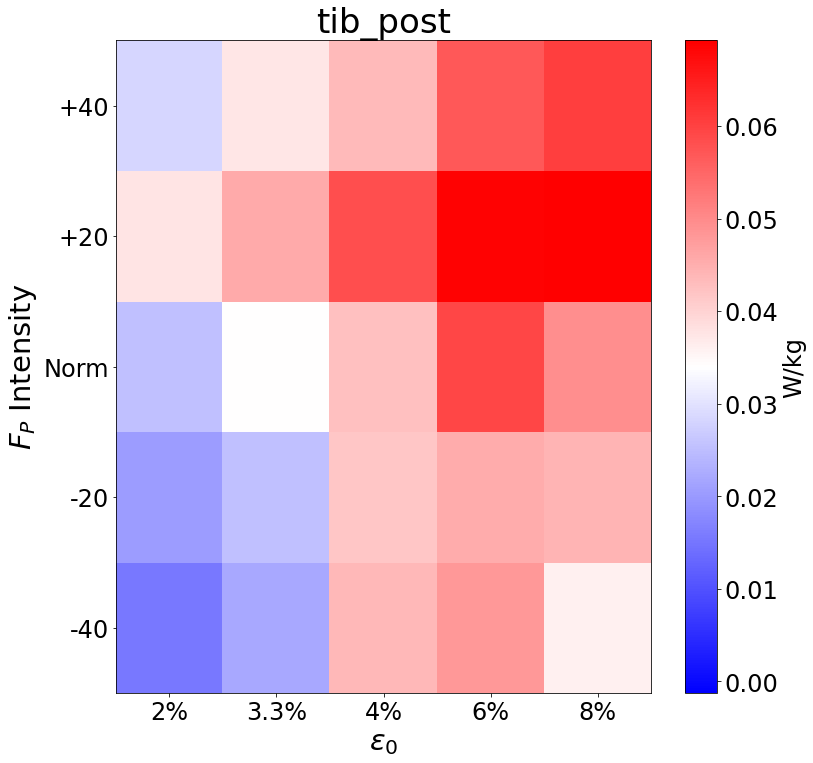

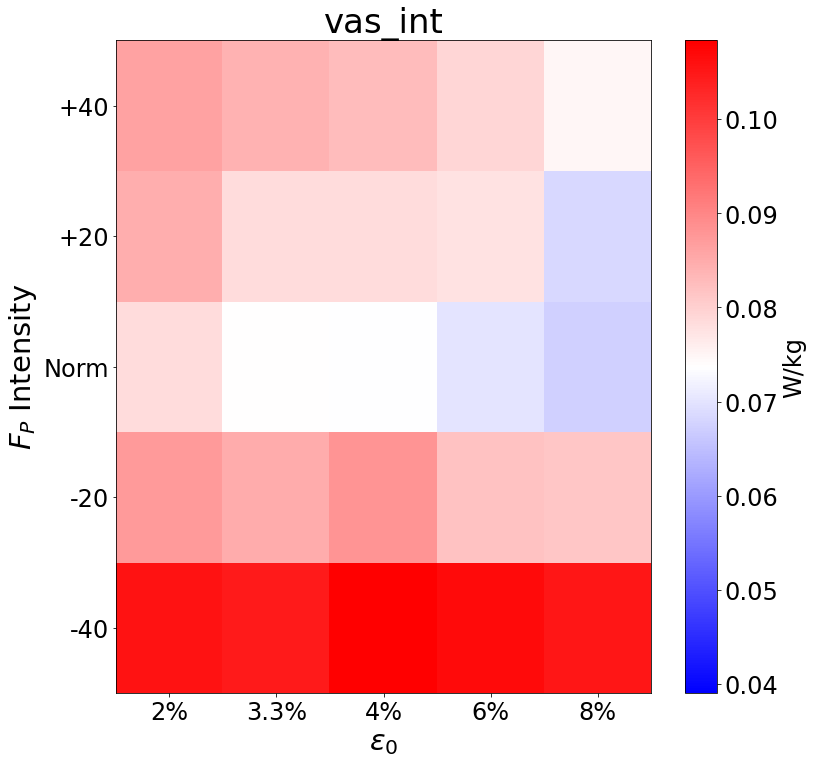

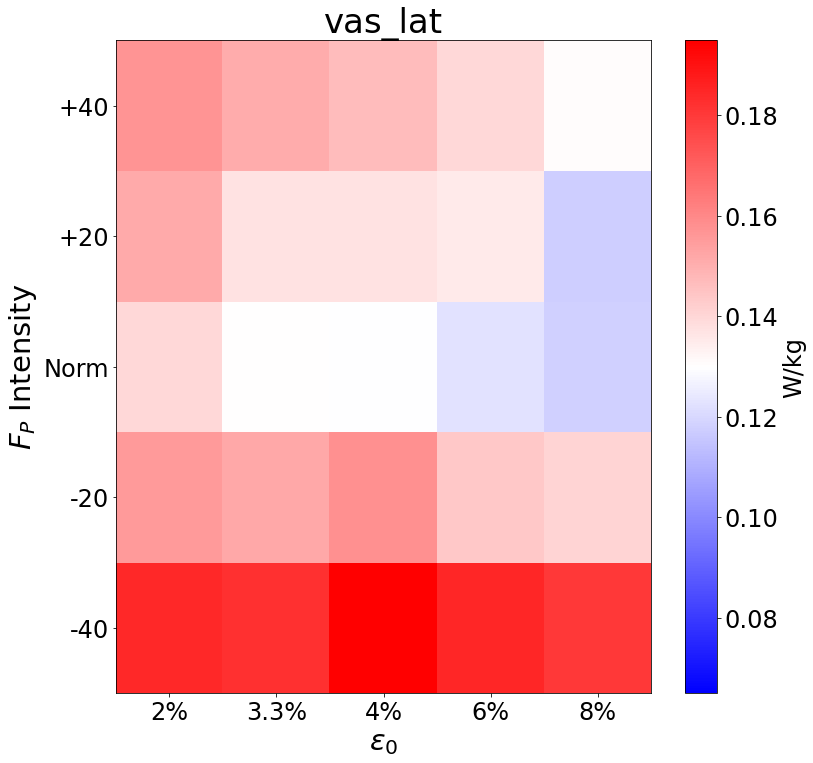

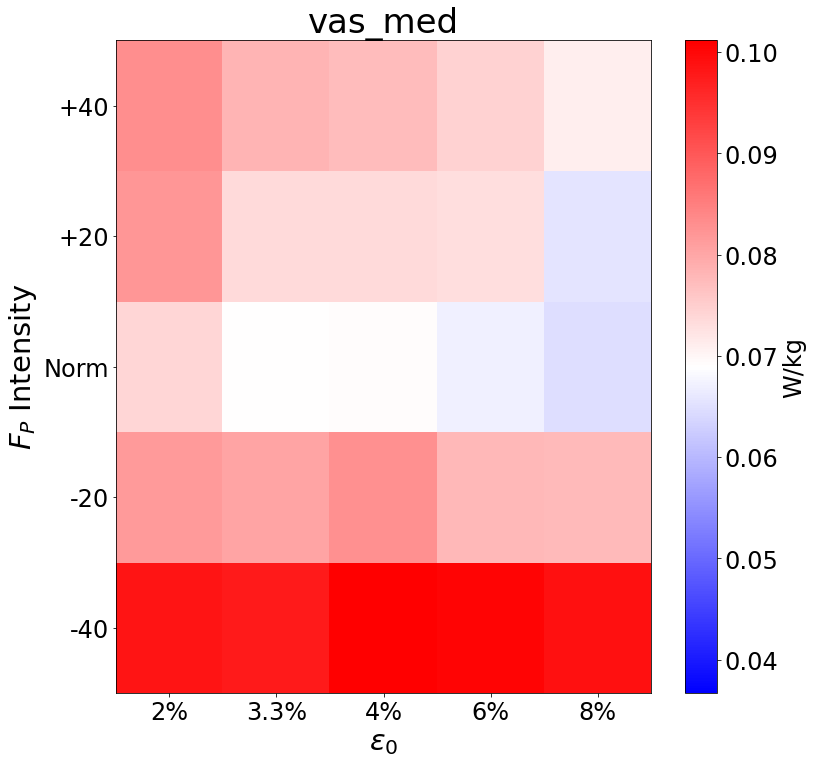

In [15]:
UniMuscCols = np.unique(MetCost['Muscles'])

Map = {}
ArrMap = {}
RMAnova = {}
Vals = []
for muscle in UniMuscCols:
    [Map[muscle], ArrMap[muscle], RMAnova[muscle]] = MakeHeatMap(muscle)
    

## Plot Gait Cycle Heat Maps for each Muscle

In [12]:
# define function to plot gait cycle heat maps
OutputFolder = os.path.join(DataFolder, 'GCHeatMaps/')

def plotGCHeatMap(musc):
  # plot heatmap across the gait cycle, tendon stiffness, and condition

  fnt = 22 # set default fig font size
  plt.rcParams.update({'font.size': fnt})

  # define conditions and fig params
  Conds = ['Fm40','Fm20','NormF','Fp20','Fp40']
  CondNames = ['-40%','-20%','Norm','+20%','+40%']
  height = [0,5,10,15,20]
  fig, ax = plt.subplots()
  fig.set_figheight(15)
  fig.set_figwidth(15)

  # define color normalization class
  class MidpointNormalize(mcolors.Normalize):
    def __init__(self, vmin=None, vmax=None, vcenter=None, clip=False):
        self.vcenter = vcenter
        super().__init__(vmin, vmax, clip)

    def __call__(self, value, clip=None):
        # ignore masked values and all kinds of edge cases for a simple example
        x, y = [self.vmin, self.vcenter, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y))

  # get average of all metabolic costs across the gait cycle for color normalization
  AllCosts = np.zeros((25, 100))
  for t in range(5):
      MuscInds = [x for x, z in enumerate(MetCost['Muscles'].tolist()) if z == musc]
      cond = Conds[t]
      CondInds = [x for x, z in enumerate(MetCost['Cond'].tolist()) if z == cond]
      match = list(set(MuscInds) & set(CondInds))
      match.sort()
      nrows = 1
      ncols = 100
      TSS = [2,3,4,6,8]
      for i in range(5): # plot individual heatmap rows
          y = np.arange(nrows+1)
          y = y + i + height[t]
          Y = np.array(MetCost.iloc[match, 4:])
          B = np.array(MetCost['StrnLvl'].iloc[match])
          AllCosts[y[0], :] = np.mean(Y[B==TSS[i]], axis=0).reshape(nrows, ncols)

  top = np.max(AllCosts) - np.mean(AllCosts)
  bot = np.mean(AllCosts) - np.min(AllCosts)
  M = max([top, bot])
  # midnorm = MidpointNormalize(vmin=np.mean(AllCosts) - M, vcenter=np.mean(AllCosts), vmax=np.mean(AllCosts) + M)
  midnorm = MidpointNormalize(vmin=0, vcenter=np.mean(AllCosts), vmax=np.mean(AllCosts) + M)
  # midnorm = MidpointNormalize(vmin=np.min(AllCosts), vcenter=np.mean(AllCosts), vmax=np.max(AllCosts))

  # loop through conditions and plot via colormesh
  for t in range(5):
      MuscInds = [x for x, z in enumerate(MetCost['Muscles'].tolist()) if z == musc]
      cond = Conds[t]
      CondInds = [x for x, z in enumerate(MetCost['Cond'].tolist()) if z == cond]
      match = list(set(MuscInds) & set(CondInds))
      match.sort()
      nrows = 1
      ncols = 100
      TSS = [2,3,4,6,8]

      for i in range(5): # plot individual heatmap rows
          x = np.arange(ncols)
          y = np.arange(nrows+1)
          y = y + i + height[t]
          
          Y = np.array(MetCost.iloc[match, 4:])
          B = np.array(MetCost['StrnLvl'].iloc[match])
          z = np.mean(Y[B==TSS[i]], axis=0).reshape(nrows, ncols)
          Z = np.repeat(z,2, axis=0)
          im = plt.pcolormesh(x, y, Z, shading='gouraud', cmap='bwr', norm=midnorm, 
                              vmin=np.mean(AllCosts) - M, vmax=np.mean(AllCosts) + M)


  # run SPM stats
  conditionsR = ['Fp40', 'Fp20', 'NormF', 'Fm20', 'Fm40']
  alpha        = 0.05
  equal_var    = False
  Total = MetCost.iloc[MuscInds, 4:]
  TotalMC = MetCost[MetCost['Muscles']=='Total'].reset_index()
  CondN = np.ones(len(TotalMC))
  Strns = np.array(TotalMC['StrnLvl'])
  Subjs = [int(float(x.replace('YA',''))) for x in TotalMC['Subj']]
  i = 0
  F = []
  Frm = []
  fi = []
  firm = []
  Ht = 25.25
  for x in conditionsR:
      CondInds = [x for x, z in enumerate(TotalMC['Cond'].tolist()) if z == conditionsR[i]]
      CondN[CondInds] = int(i + 1)
      i = i+1 
      
  F = spm1d.stats.anova2(Total, CondN, Strns, equal_var=True)  #between-subjects
  Frm = spm1d.stats.anova2rm(Total, CondN, Strns, Subjs)  #within-subjects (repeated-measures)
  fi.append(F.inference(alpha))
  firm.append(Frm.inference(alpha))
  Fi = F.inference(alpha)
  Firm = Frm.inference(alpha) 

  for x in range(len(Firm[0].z)):
      # effect of interaction
      if Firm[2].z[x] > Firm[2].zstar:
        ax.add_patch(Rectangle((x, 25), 1, 2, 
                      facecolor='k', alpha=0.4))

      # effect of strain
      if Firm[1].z[x] > Firm[1].zstar:
          ax.add_patch(Rectangle((x, Ht), 1, 0.5, 
                          facecolor='k'))
          
      #effect of condition
      if Firm[0].z[x] > Firm[0].zstar:
          ax.add_patch(Rectangle((x, Ht+1), 1, 0.5, 
                      facecolor='k'))

  ax.text(-4, Ht+0.25, r'$\epsilon_0$', va='center', fontsize=fnt)
  ax.text(-4, Ht+1.25, r'$F_P$', va='center', fontsize=fnt)

  # edit axes
  cb = plt.colorbar(im, label='Instantaneous Metabolic Cost (W/kg)', orientation='horizontal', pad=0.08, 
                    boundaries=np.linspace(0, np.max(AllCosts), 100),
                    ticks=np.round(np.linspace(0, np.max(AllCosts), 5, endpoint=True), 3))
  
  ax.set_yticks(np.linspace(0.5, 24.5, 25))
  TSSvals = ['2%','3.3%','4%','6%','8%']
  ax.set_yticklabels(np.tile(TSSvals, 5), fontsize=fnt-5)
  ax.set_ylabel(r'$\epsilon_0$', fontsize=fnt+8)
  ax.set_xlabel('% Gait Cycle', fontsize=fnt+3)
  ax.set_xlim(0,99)
  ax.set_ylim(0,27)
  ax.hlines([5, 10, 15, 20], 0, 100, 'w', linewidth=5)
  ax.hlines(25, -5, 100, 'k', linewidth=2)
  ax.set_title(musc, fontsize=fnt+20, pad=25, weight = 'bold')
  yvals = [2.5, 7.5, 12.5, 17.5, 22.5]
  for i in range(5):
      ax.text(101, yvals[i], CondNames[i], rotation='vertical', ha='center', va='center', fontsize=fnt)
  ax.text(105, 13, '$F_{P}$ Intensity', rotation='vertical', ha='center', va='center', fontsize=fnt+5)

  fig.savefig('GCHeatMaps/' + musc+'_GCHeatmap.png')
  fig.savefig('GCHeatMaps/' + musc+'_GCHeatmap.pdf')

Total


/usr/local/lib/python3.7/dist-packages/spm1d/stats/anova/ui.py:226: UserWarning: 

  if ((model.dim == 1) or _force_approx0D)   and   ( design.check_for_single_responses(dim=model.dim) ):


add_brev


/usr/local/lib/python3.7/dist-packages/spm1d/stats/anova/ui.py:226: UserWarning: 

  if ((model.dim == 1) or _force_approx0D)   and   ( design.check_for_single_responses(dim=model.dim) ):


add_long


/usr/local/lib/python3.7/dist-packages/spm1d/stats/anova/ui.py:226: UserWarning: 

  if ((model.dim == 1) or _force_approx0D)   and   ( design.check_for_single_responses(dim=model.dim) ):


add_mag


/usr/local/lib/python3.7/dist-packages/spm1d/stats/anova/ui.py:226: UserWarning: 

  if ((model.dim == 1) or _force_approx0D)   and   ( design.check_for_single_responses(dim=model.dim) ):


bifemlh


/usr/local/lib/python3.7/dist-packages/spm1d/stats/anova/ui.py:226: UserWarning: 

  if ((model.dim == 1) or _force_approx0D)   and   ( design.check_for_single_responses(dim=model.dim) ):


bifemsh


/usr/local/lib/python3.7/dist-packages/spm1d/stats/anova/ui.py:226: UserWarning: 

  if ((model.dim == 1) or _force_approx0D)   and   ( design.check_for_single_responses(dim=model.dim) ):


ercspn


/usr/local/lib/python3.7/dist-packages/spm1d/stats/anova/ui.py:226: UserWarning: 

  if ((model.dim == 1) or _force_approx0D)   and   ( design.check_for_single_responses(dim=model.dim) ):


ext_dig


/usr/local/lib/python3.7/dist-packages/spm1d/stats/anova/ui.py:226: UserWarning: 

  if ((model.dim == 1) or _force_approx0D)   and   ( design.check_for_single_responses(dim=model.dim) ):


ext_hal


/usr/local/lib/python3.7/dist-packages/spm1d/stats/anova/ui.py:226: UserWarning: 

  if ((model.dim == 1) or _force_approx0D)   and   ( design.check_for_single_responses(dim=model.dim) ):


extobl


/usr/local/lib/python3.7/dist-packages/spm1d/stats/anova/ui.py:226: UserWarning: 

  if ((model.dim == 1) or _force_approx0D)   and   ( design.check_for_single_responses(dim=model.dim) ):


flex_dig


/usr/local/lib/python3.7/dist-packages/spm1d/stats/anova/ui.py:226: UserWarning: 

  if ((model.dim == 1) or _force_approx0D)   and   ( design.check_for_single_responses(dim=model.dim) ):


flex_hal


/usr/local/lib/python3.7/dist-packages/spm1d/stats/anova/ui.py:226: UserWarning: 

  if ((model.dim == 1) or _force_approx0D)   and   ( design.check_for_single_responses(dim=model.dim) ):


gem


/usr/local/lib/python3.7/dist-packages/spm1d/stats/anova/ui.py:226: UserWarning: 

  if ((model.dim == 1) or _force_approx0D)   and   ( design.check_for_single_responses(dim=model.dim) ):


glut_max


/usr/local/lib/python3.7/dist-packages/spm1d/stats/anova/ui.py:226: UserWarning: 

  if ((model.dim == 1) or _force_approx0D)   and   ( design.check_for_single_responses(dim=model.dim) ):


glut_med


/usr/local/lib/python3.7/dist-packages/spm1d/stats/anova/ui.py:226: UserWarning: 

  if ((model.dim == 1) or _force_approx0D)   and   ( design.check_for_single_responses(dim=model.dim) ):


glut_min


/usr/local/lib/python3.7/dist-packages/spm1d/stats/anova/ui.py:226: UserWarning: 

  if ((model.dim == 1) or _force_approx0D)   and   ( design.check_for_single_responses(dim=model.dim) ):


grac


/usr/local/lib/python3.7/dist-packages/spm1d/stats/anova/ui.py:226: UserWarning: 

  if ((model.dim == 1) or _force_approx0D)   and   ( design.check_for_single_responses(dim=model.dim) ):


iliacus


/usr/local/lib/python3.7/dist-packages/spm1d/stats/anova/ui.py:226: UserWarning: 

  if ((model.dim == 1) or _force_approx0D)   and   ( design.check_for_single_responses(dim=model.dim) ):


intobl


/usr/local/lib/python3.7/dist-packages/spm1d/stats/anova/ui.py:226: UserWarning: 

  if ((model.dim == 1) or _force_approx0D)   and   ( design.check_for_single_responses(dim=model.dim) ):


lat_gas


/usr/local/lib/python3.7/dist-packages/spm1d/stats/anova/ui.py:226: UserWarning: 

  if ((model.dim == 1) or _force_approx0D)   and   ( design.check_for_single_responses(dim=model.dim) ):


med_gas


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  from ipykernel import kernelapp as app
/usr/local/lib/python3.7/dist-packages/spm1d/stats/anova/ui.py:226: UserWarning: 

  if ((model.dim == 1) or _force_approx0D)   and   ( design.check_for_single_responses(dim=model.dim) ):


pect


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  from ipykernel import kernelapp as app
/usr/local/lib/python3.7/dist-packages/spm1d/stats/anova/ui.py:226: UserWarning: 

  if ((model.dim == 1) or _force_approx0D)   and   ( design.check_for_single_responses(dim=model.dim) ):


per_brev


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  from ipykernel import kernelapp as app
/usr/local/lib/python3.7/dist-packages/spm1d/stats/anova/ui.py:226: UserWarning: 

  if ((model.dim == 1) or _force_approx0D)   and   ( design.check_for_single_responses(dim=model.dim) ):


per_long


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  from ipykernel import kernelapp as app
/usr/local/lib/python3.7/dist-packages/spm1d/stats/anova/ui.py:226: UserWarning: 

  if ((model.dim == 1) or _force_approx0D)   and   ( design.check_for_single_responses(dim=model.dim) ):


per_tert


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  from ipykernel import kernelapp as app
/usr/local/lib/python3.7/dist-packages/spm1d/stats/anova/ui.py:226: UserWarning: 

  if ((model.dim == 1) or _force_approx0D)   and   ( design.check_for_single_responses(dim=model.dim) ):


peri


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  from ipykernel import kernelapp as app
/usr/local/lib/python3.7/dist-packages/spm1d/stats/anova/ui.py:226: UserWarning: 

  if ((model.dim == 1) or _force_approx0D)   and   ( design.check_for_single_responses(dim=model.dim) ):


psoas


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  from ipykernel import kernelapp as app
/usr/local/lib/python3.7/dist-packages/spm1d/stats/anova/ui.py:226: UserWarning: 

  if ((model.dim == 1) or _force_approx0D)   and   ( design.check_for_single_responses(dim=model.dim) ):


quad_fem


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  from ipykernel import kernelapp as app
/usr/local/lib/python3.7/dist-packages/spm1d/stats/anova/ui.py:226: UserWarning: 

  if ((model.dim == 1) or _force_approx0D)   and   ( design.check_for_single_responses(dim=model.dim) ):


rect_fem


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  from ipykernel import kernelapp as app
/usr/local/lib/python3.7/dist-packages/spm1d/stats/anova/ui.py:226: UserWarning: 

  if ((model.dim == 1) or _force_approx0D)   and   ( design.check_for_single_responses(dim=model.dim) ):


sar


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  from ipykernel import kernelapp as app
/usr/local/lib/python3.7/dist-packages/spm1d/stats/anova/ui.py:226: UserWarning: 

  if ((model.dim == 1) or _force_approx0D)   and   ( design.check_for_single_responses(dim=model.dim) ):


semimem


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  from ipykernel import kernelapp as app
/usr/local/lib/python3.7/dist-packages/spm1d/stats/anova/ui.py:226: UserWarning: 

  if ((model.dim == 1) or _force_approx0D)   and   ( design.check_for_single_responses(dim=model.dim) ):


semiten


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  from ipykernel import kernelapp as app
/usr/local/lib/python3.7/dist-packages/spm1d/stats/anova/ui.py:226: UserWarning: 

  if ((model.dim == 1) or _force_approx0D)   and   ( design.check_for_single_responses(dim=model.dim) ):


soleus


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  from ipykernel import kernelapp as app
/usr/local/lib/python3.7/dist-packages/spm1d/stats/anova/ui.py:226: UserWarning: 

  if ((model.dim == 1) or _force_approx0D)   and   ( design.check_for_single_responses(dim=model.dim) ):


tfl


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  from ipykernel import kernelapp as app
/usr/local/lib/python3.7/dist-packages/spm1d/stats/anova/ui.py:226: UserWarning: 

  if ((model.dim == 1) or _force_approx0D)   and   ( design.check_for_single_responses(dim=model.dim) ):


tib_ant


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  from ipykernel import kernelapp as app
/usr/local/lib/python3.7/dist-packages/spm1d/stats/anova/ui.py:226: UserWarning: 

  if ((model.dim == 1) or _force_approx0D)   and   ( design.check_for_single_responses(dim=model.dim) ):


tib_post


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  from ipykernel import kernelapp as app
/usr/local/lib/python3.7/dist-packages/spm1d/stats/anova/ui.py:226: UserWarning: 

  if ((model.dim == 1) or _force_approx0D)   and   ( design.check_for_single_responses(dim=model.dim) ):


vas_int


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  from ipykernel import kernelapp as app
/usr/local/lib/python3.7/dist-packages/spm1d/stats/anova/ui.py:226: UserWarning: 

  if ((model.dim == 1) or _force_approx0D)   and   ( design.check_for_single_responses(dim=model.dim) ):


vas_lat


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  from ipykernel import kernelapp as app
/usr/local/lib/python3.7/dist-packages/spm1d/stats/anova/ui.py:226: UserWarning: 

  if ((model.dim == 1) or _force_approx0D)   and   ( design.check_for_single_responses(dim=model.dim) ):


vas_med


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  from ipykernel import kernelapp as app
/usr/local/lib/python3.7/dist-packages/spm1d/stats/anova/ui.py:226: UserWarning: 

  if ((model.dim == 1) or _force_approx0D)   and   ( design.check_for_single_responses(dim=model.dim) ):


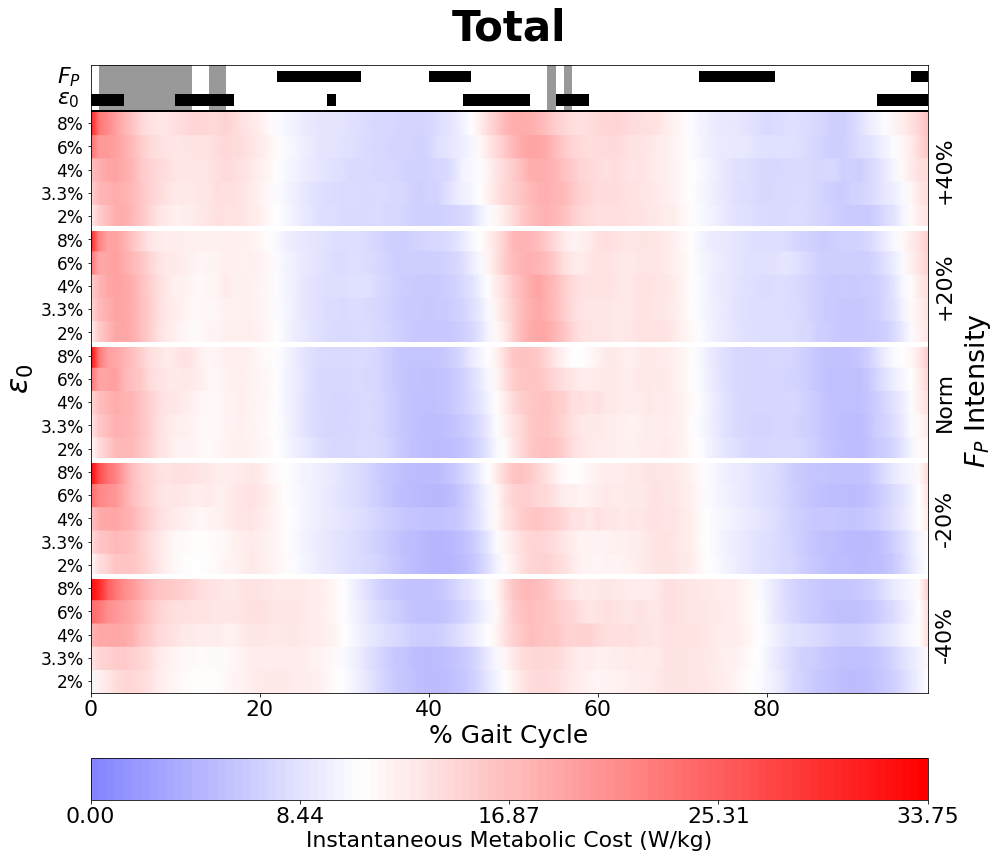

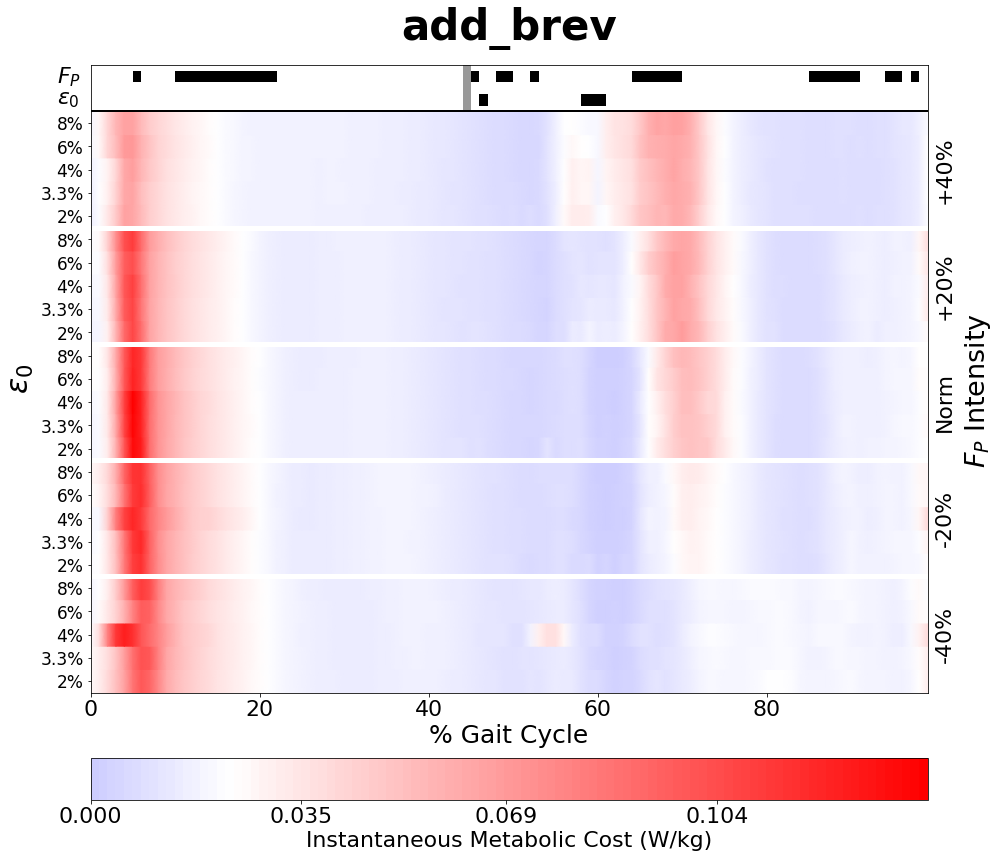

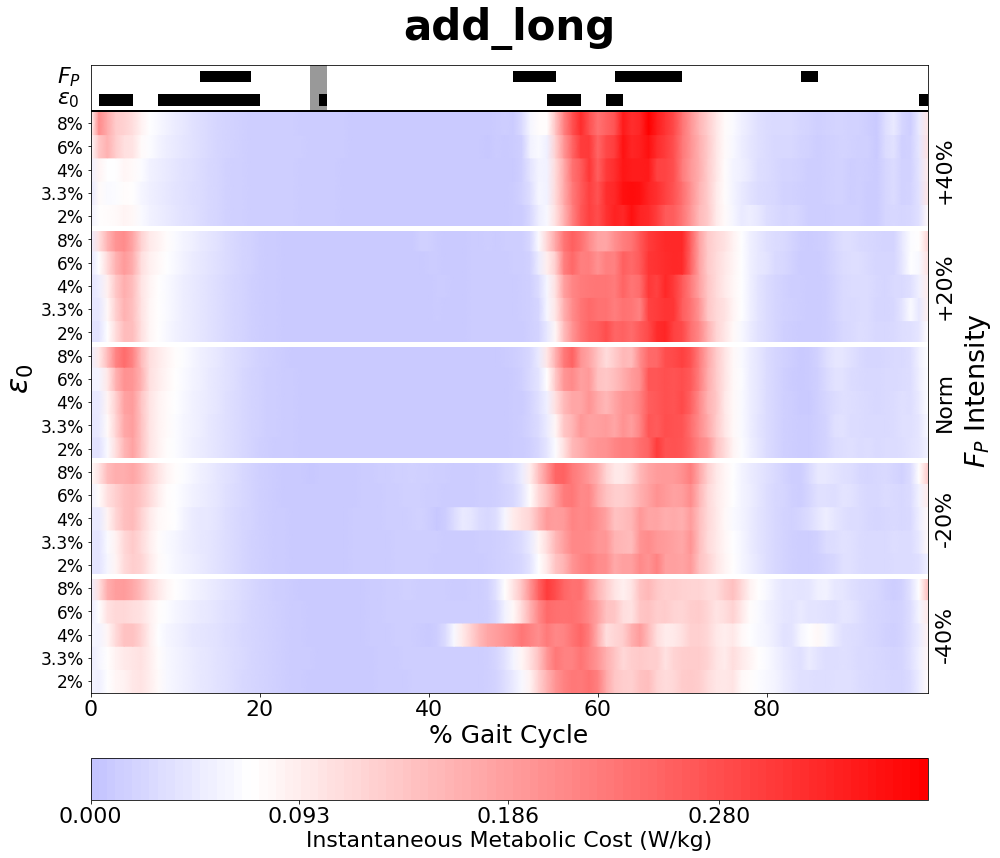

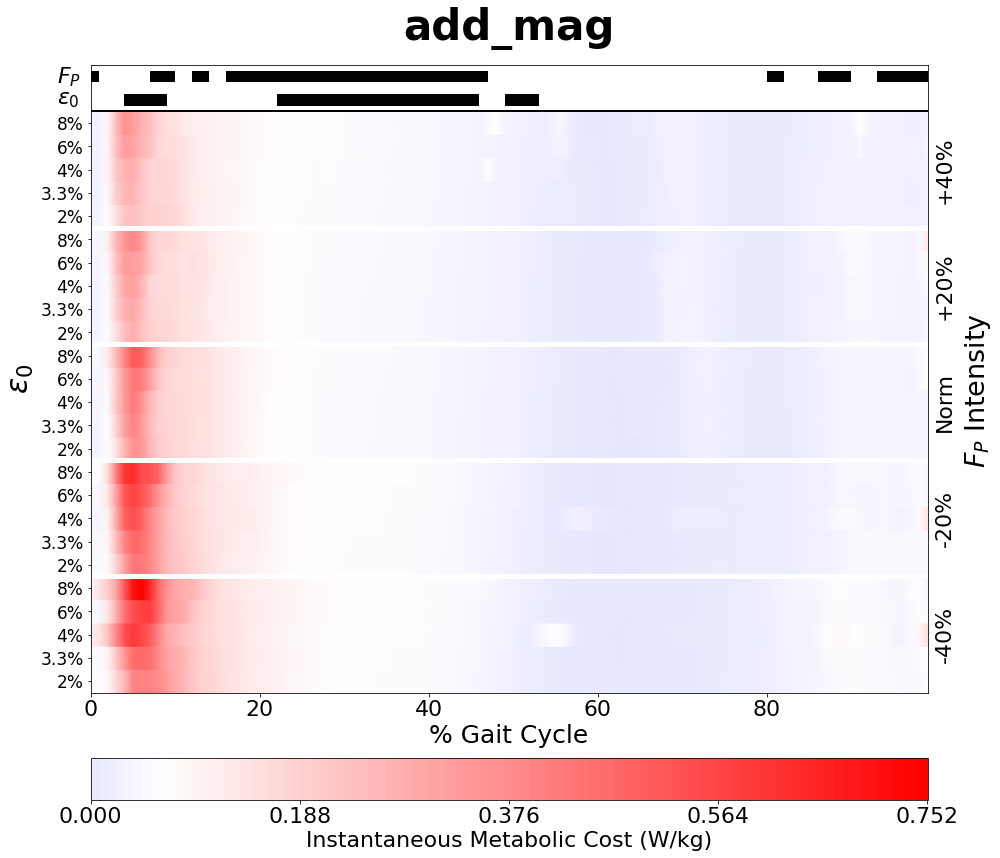

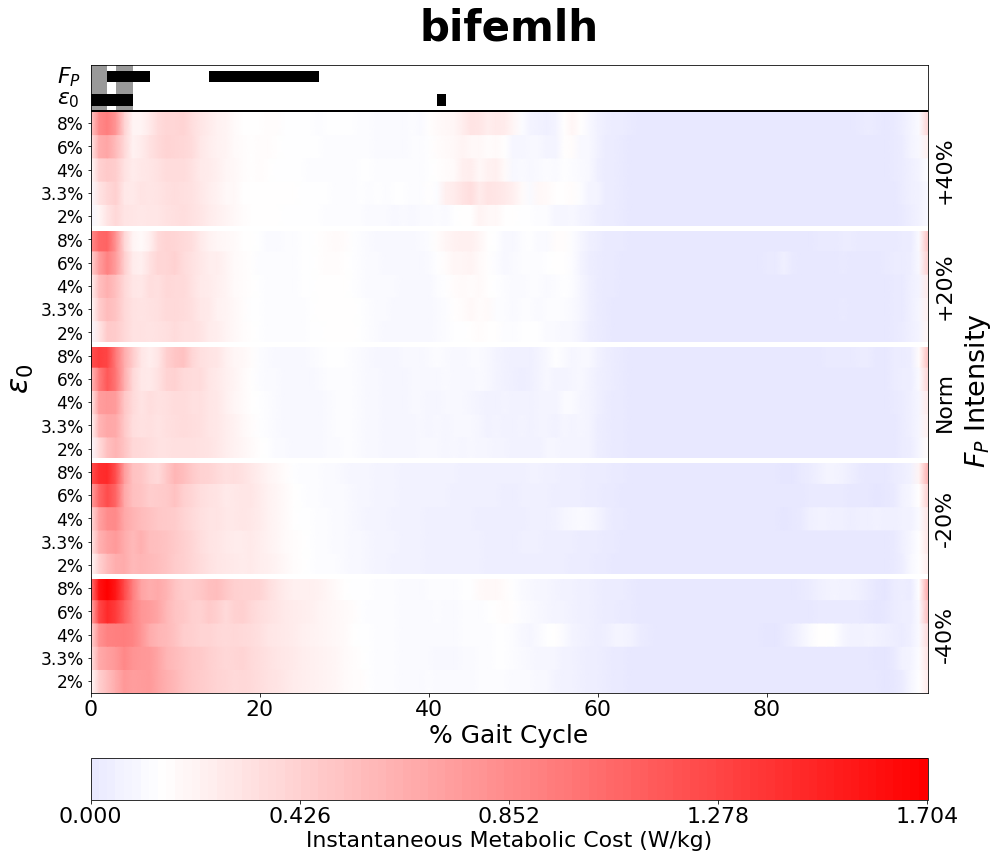

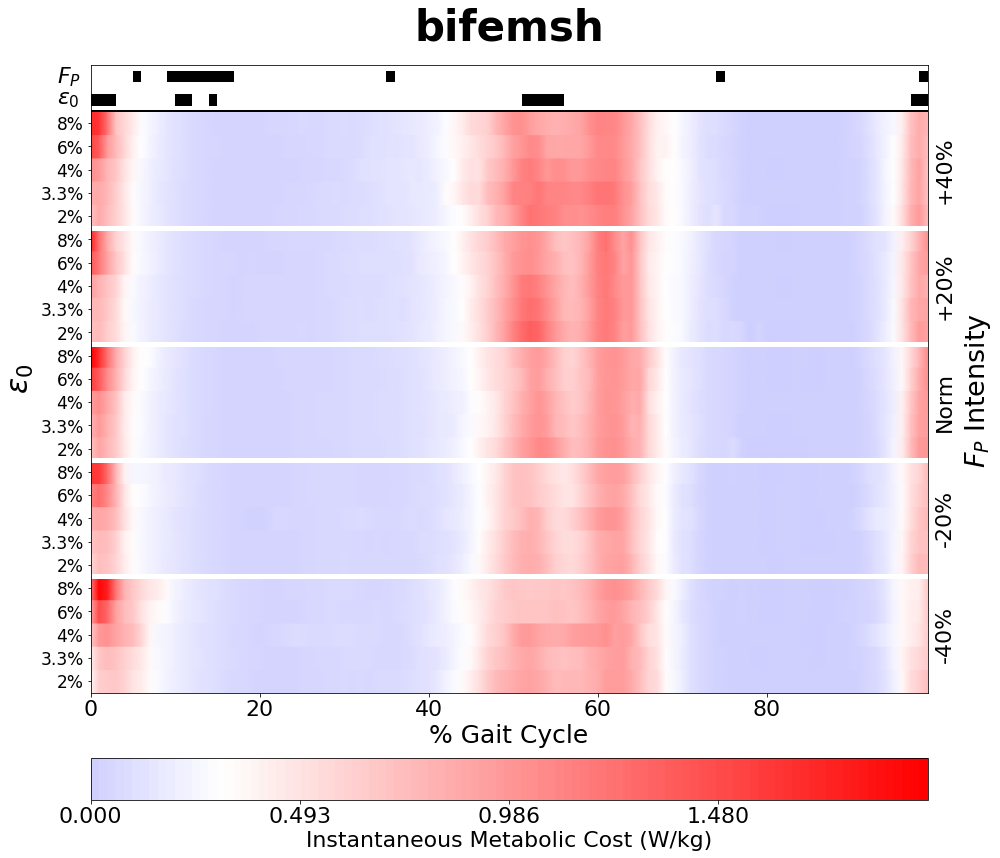

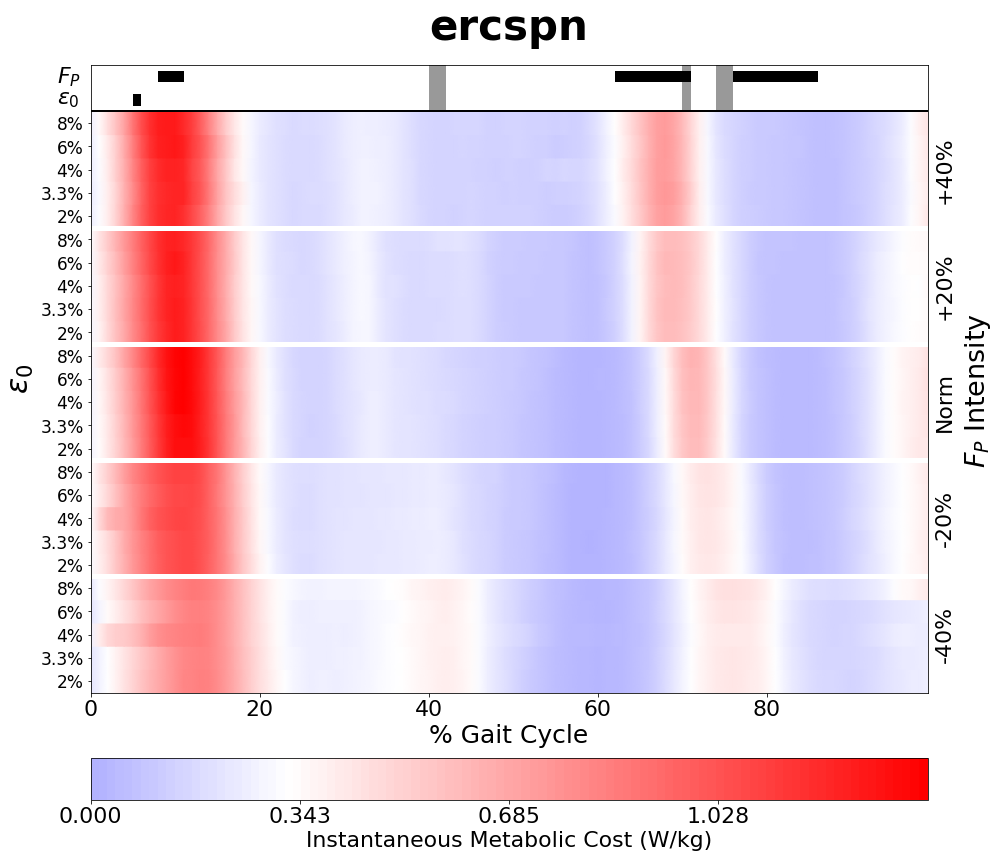

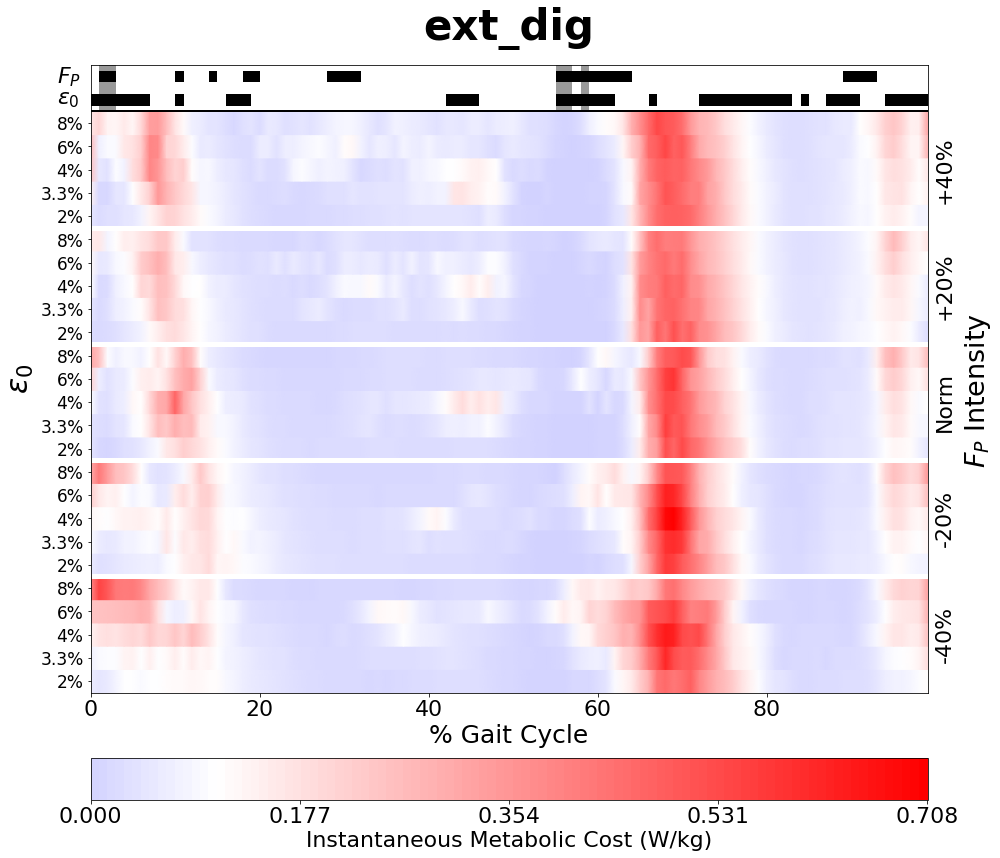

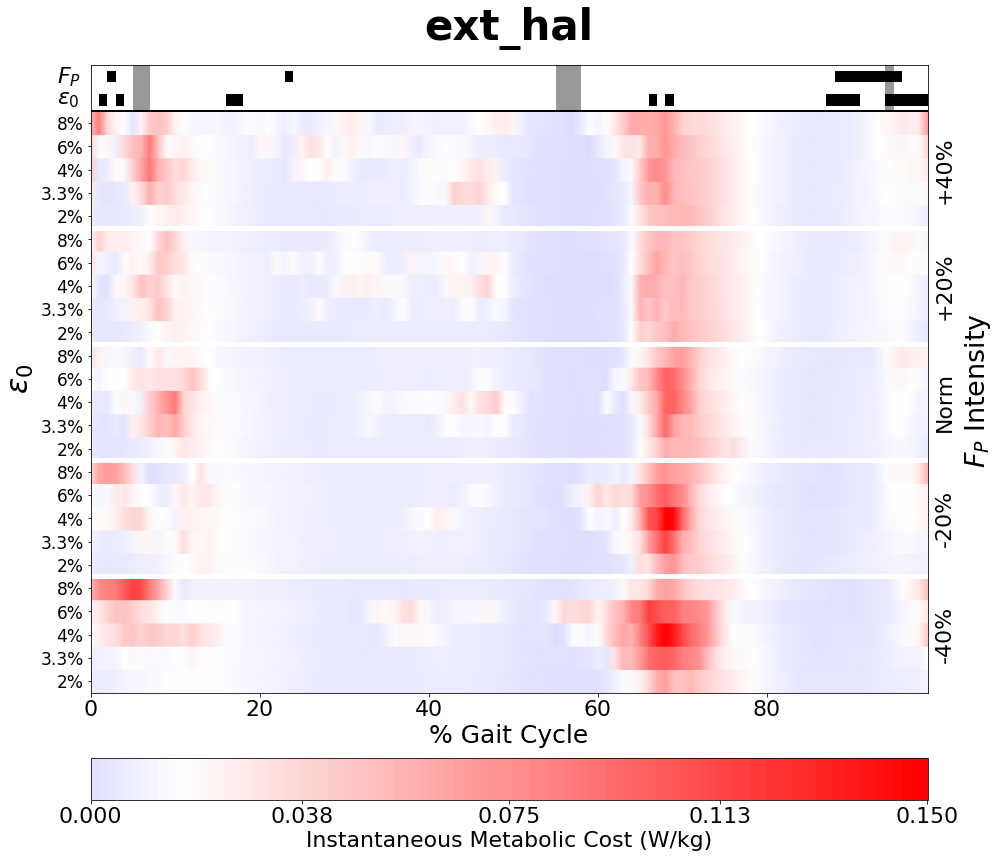

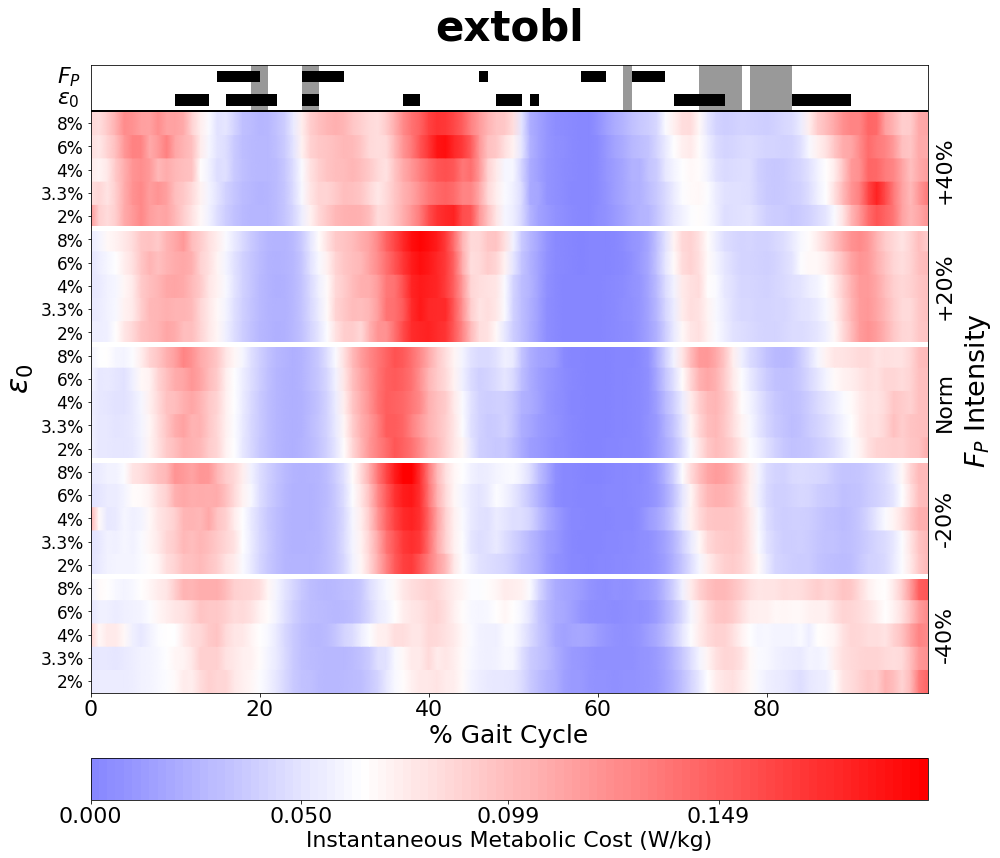

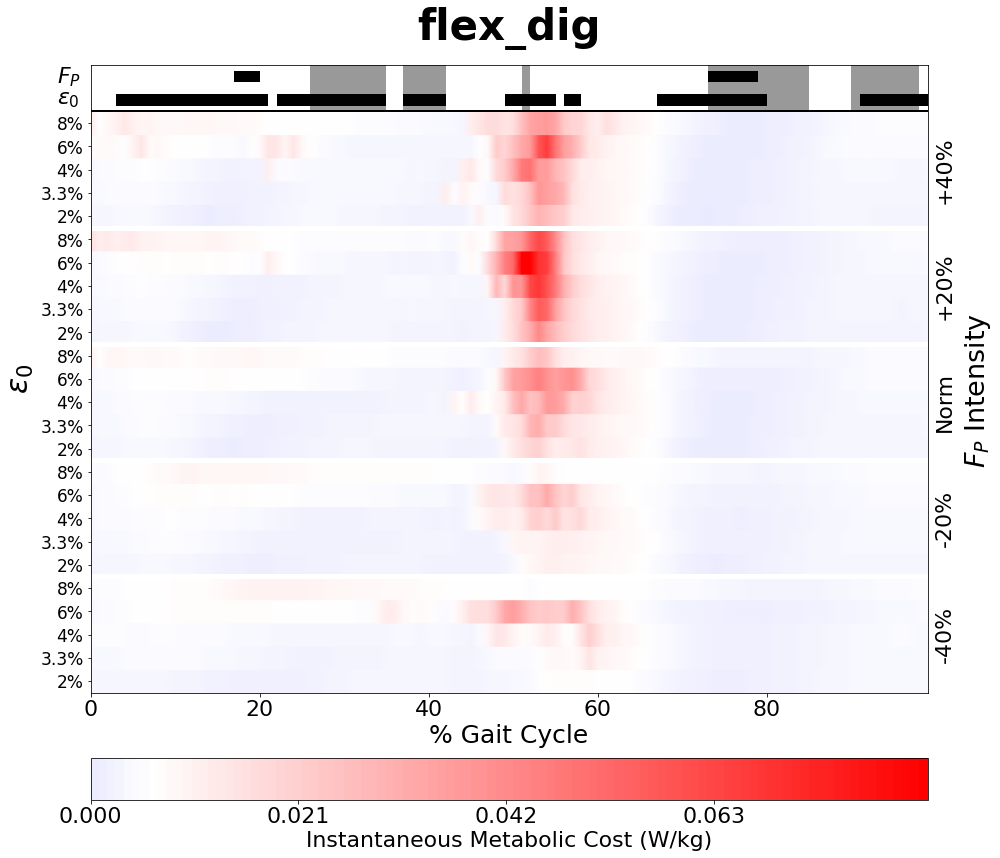

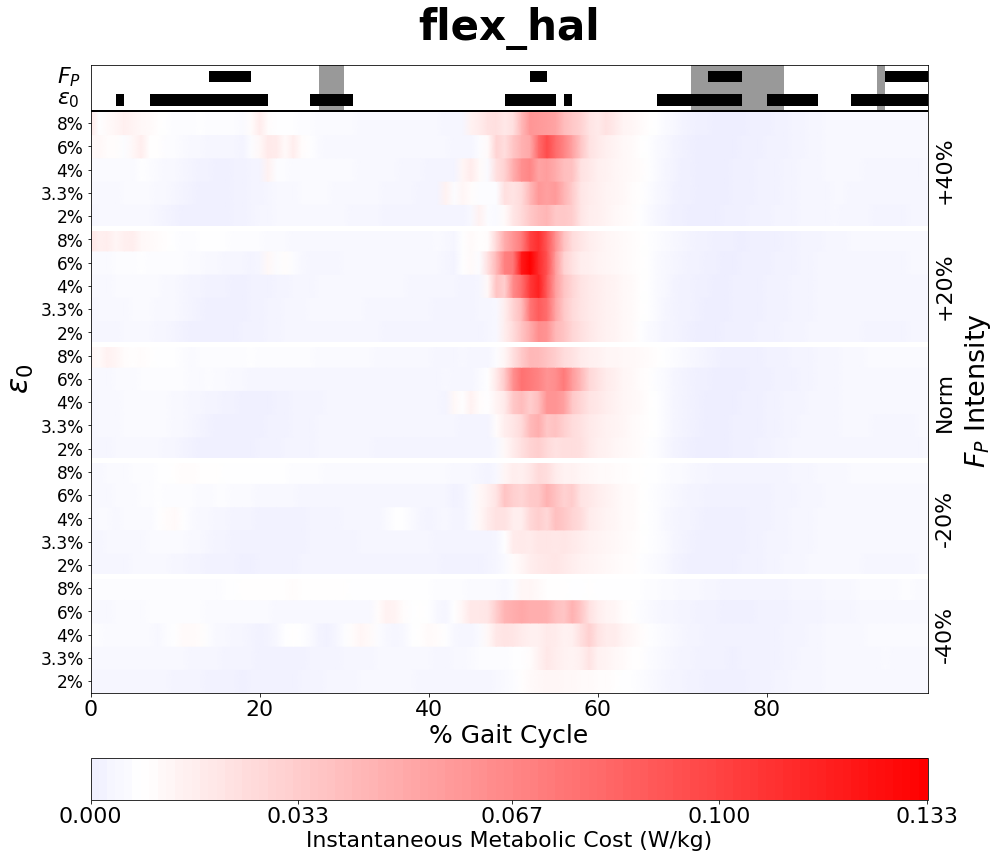

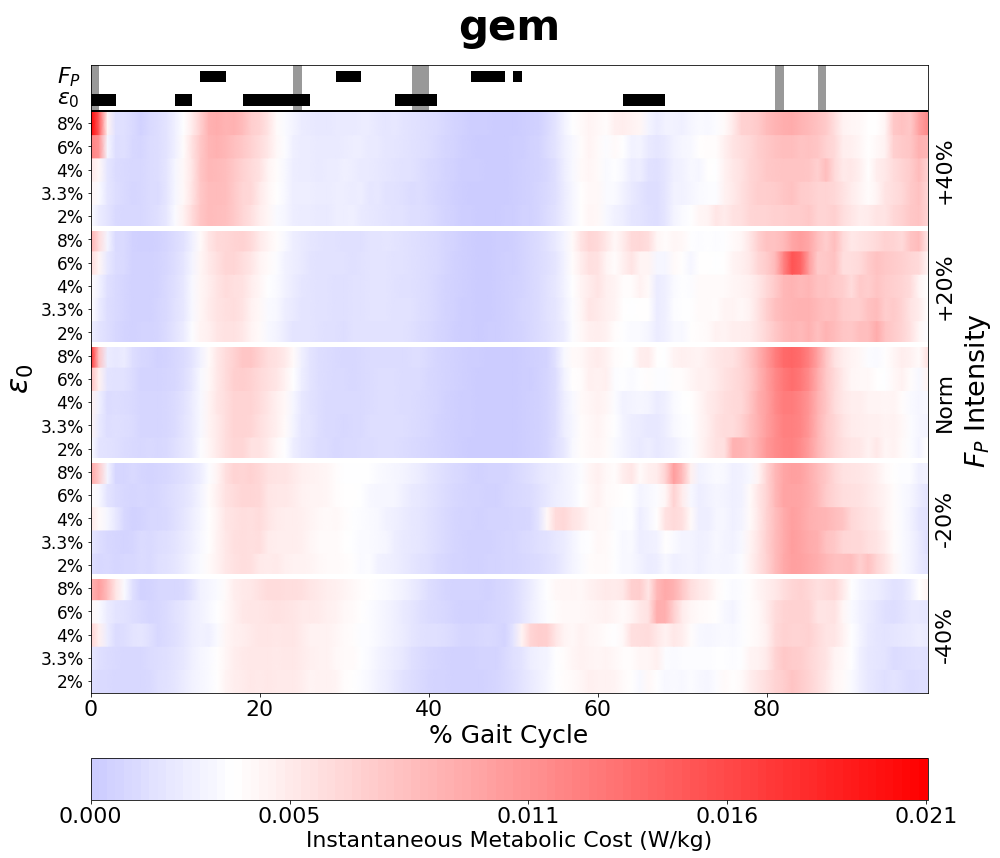

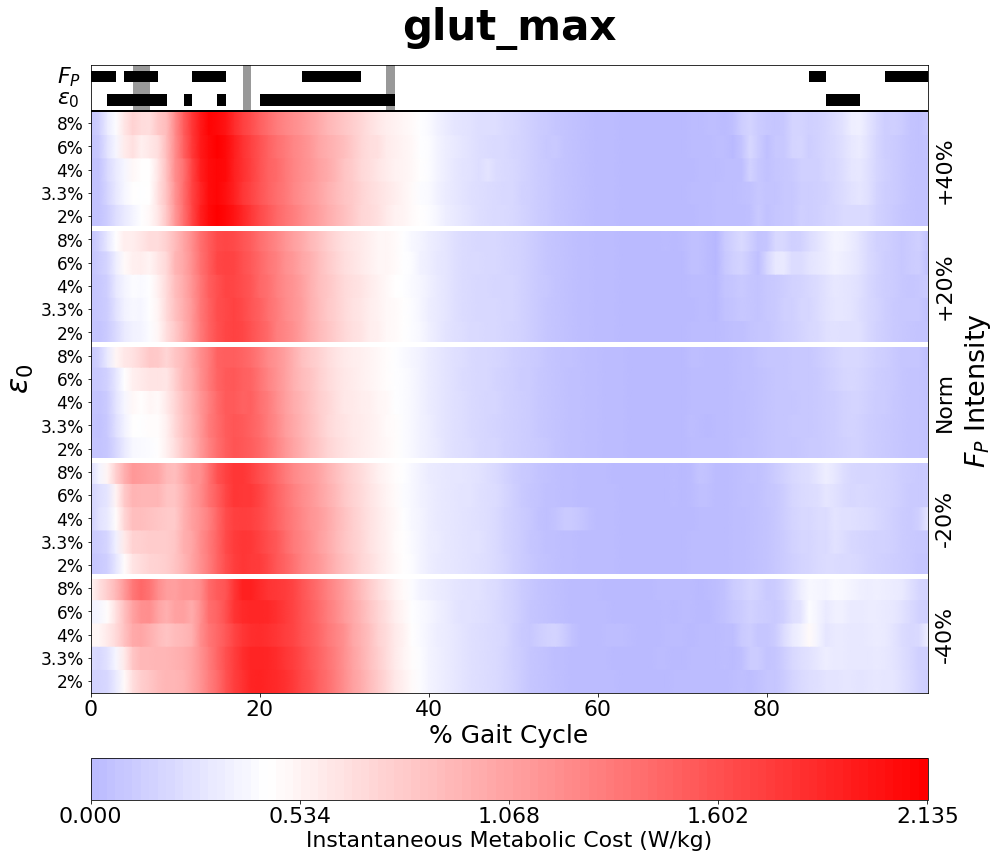

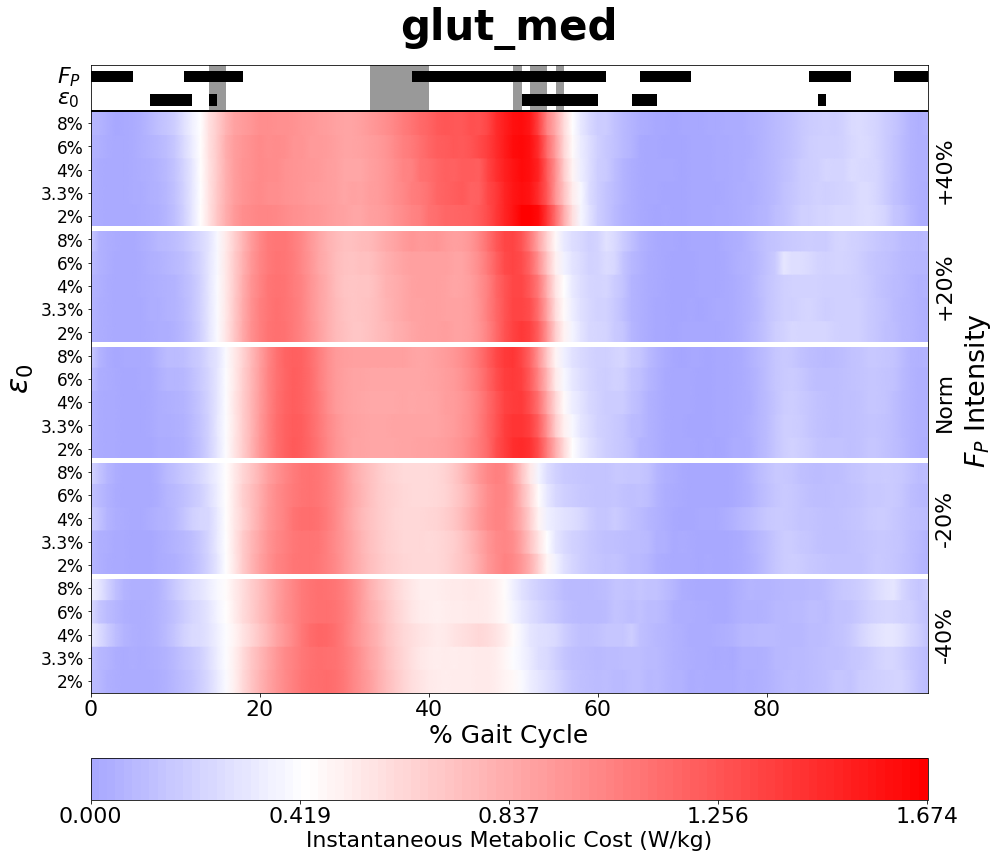

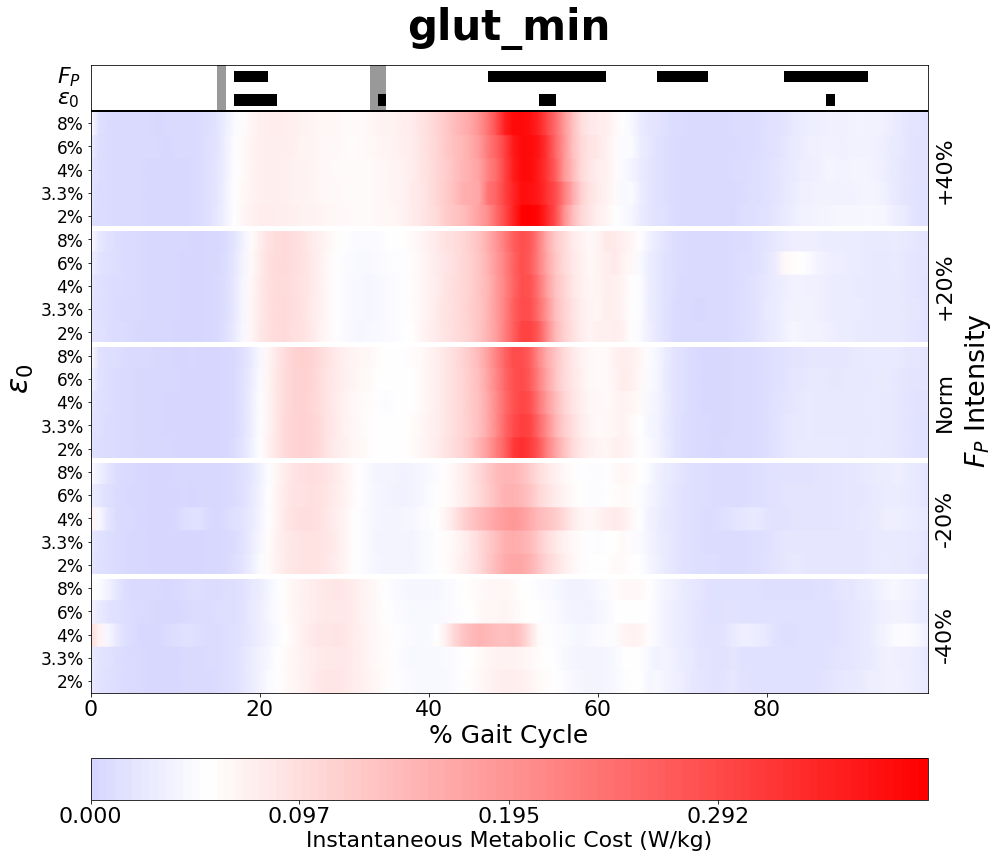

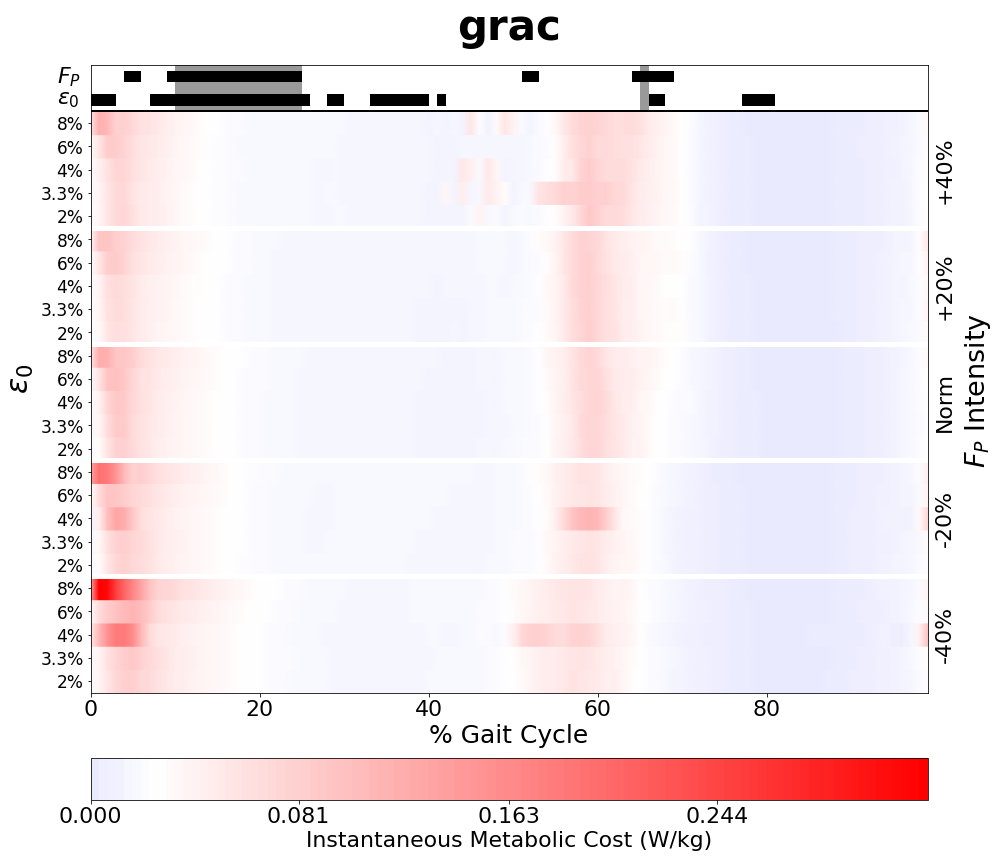

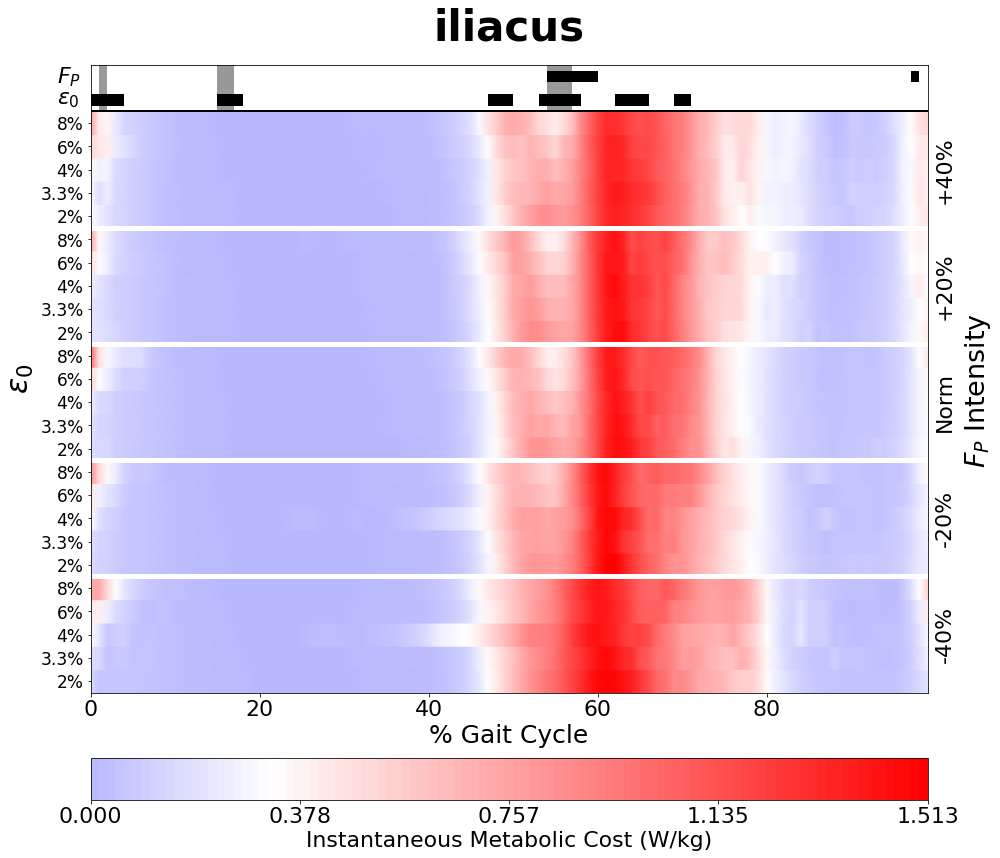

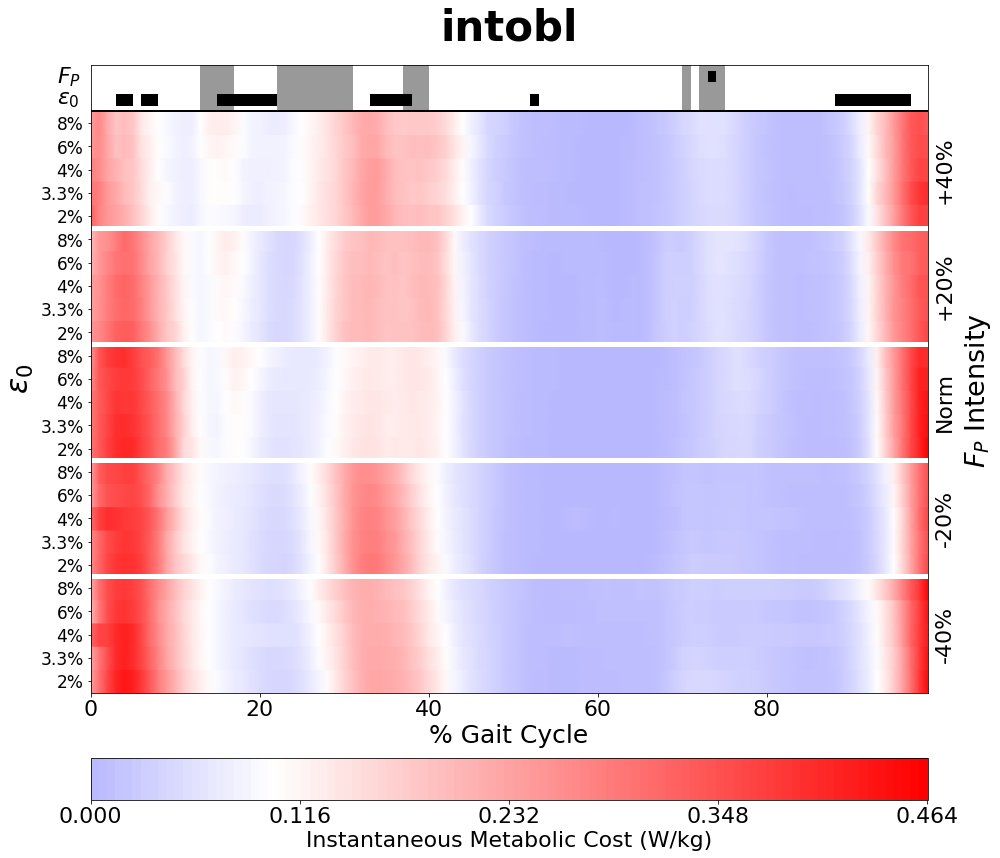

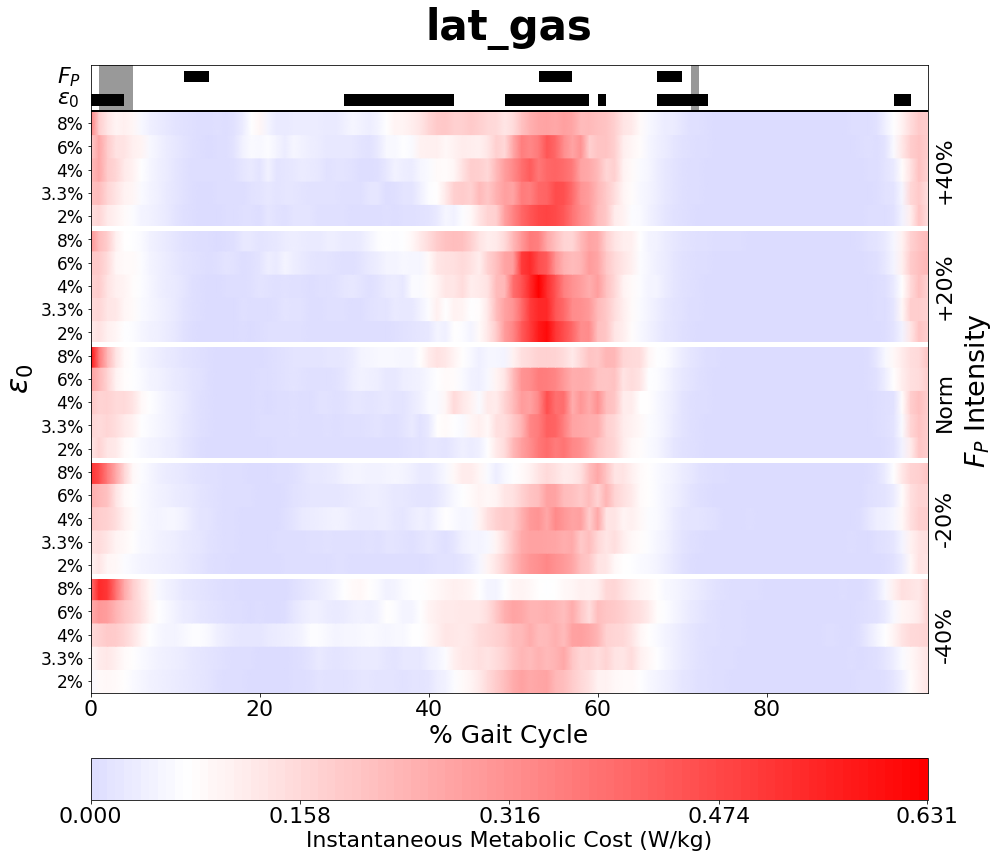

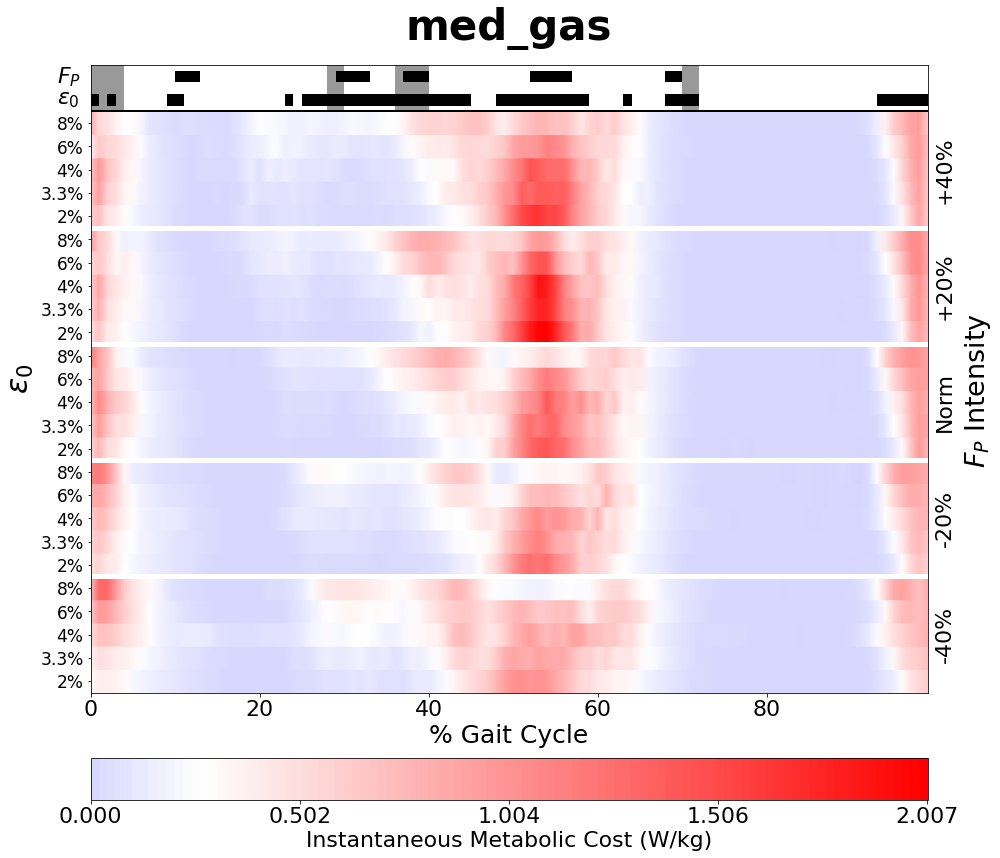

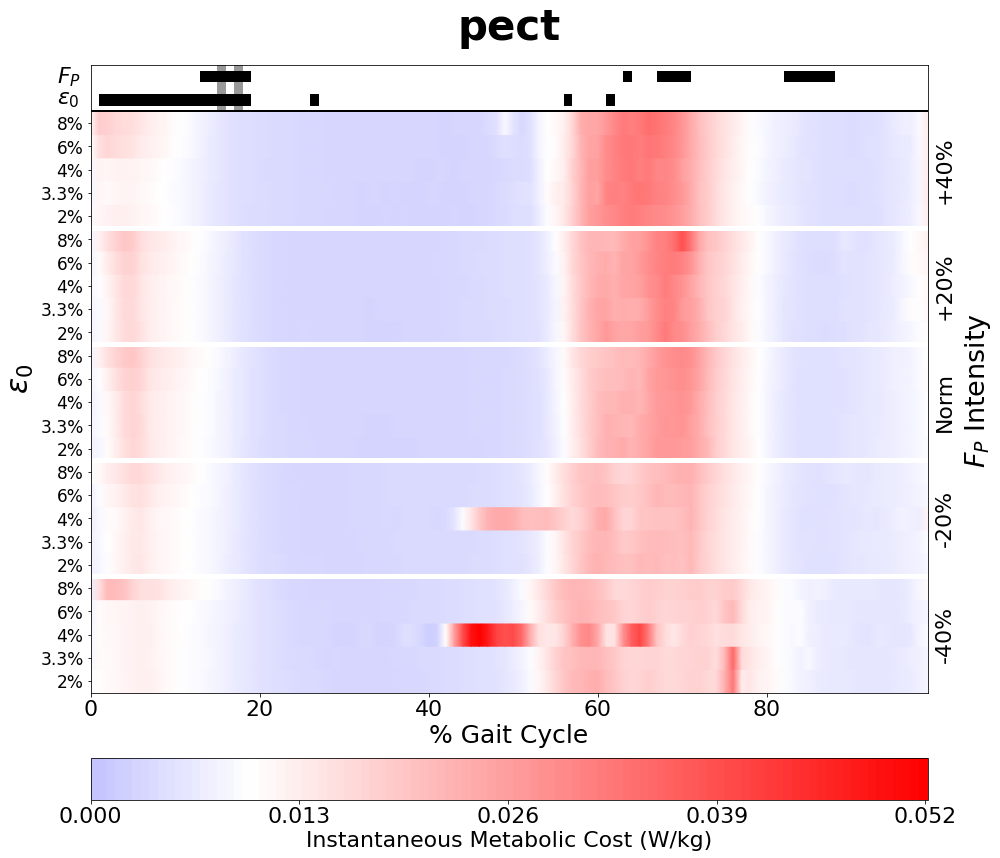

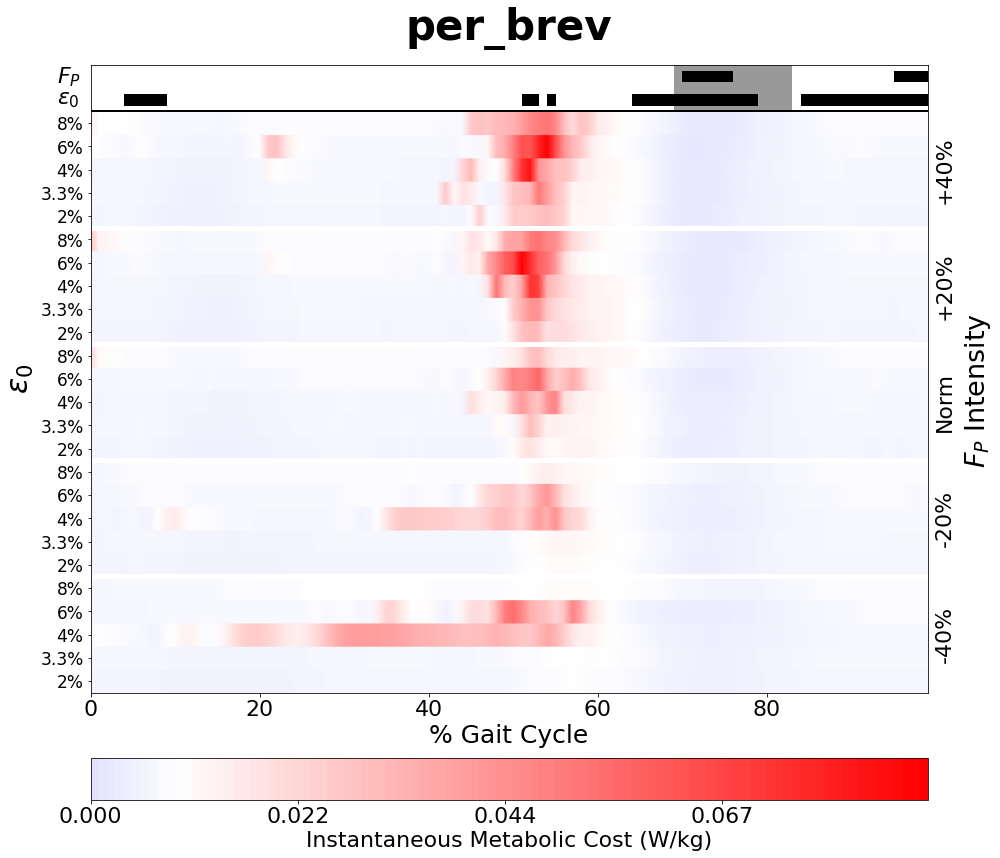

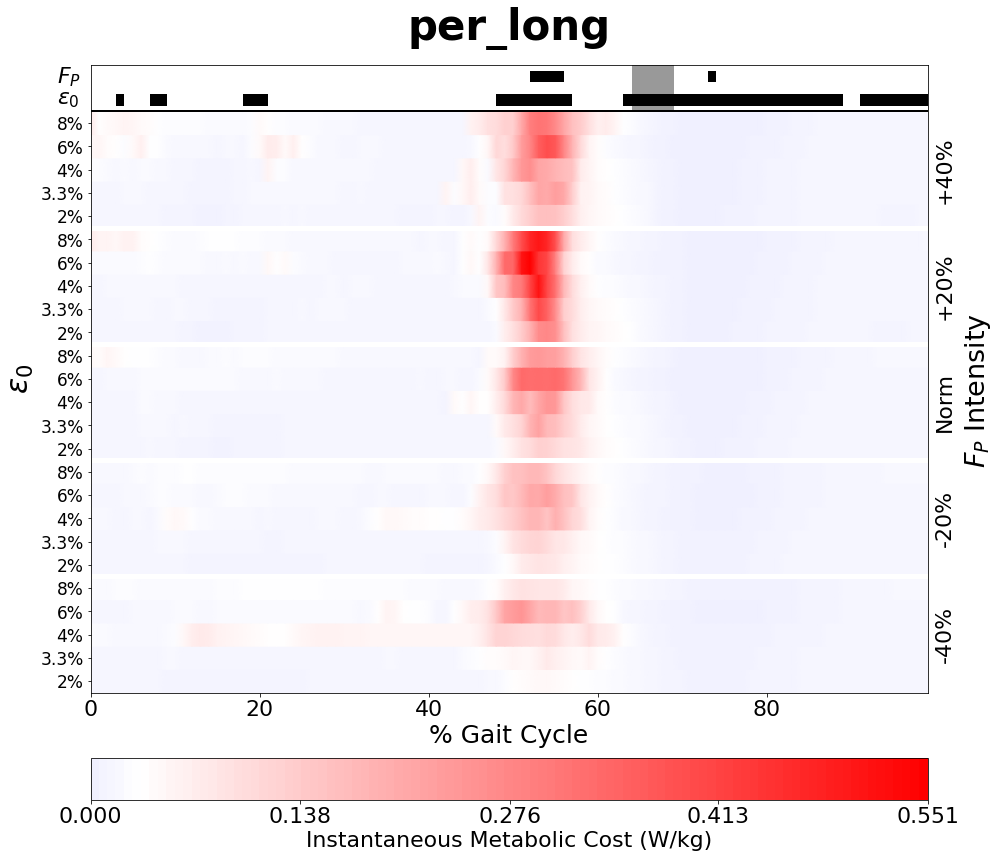

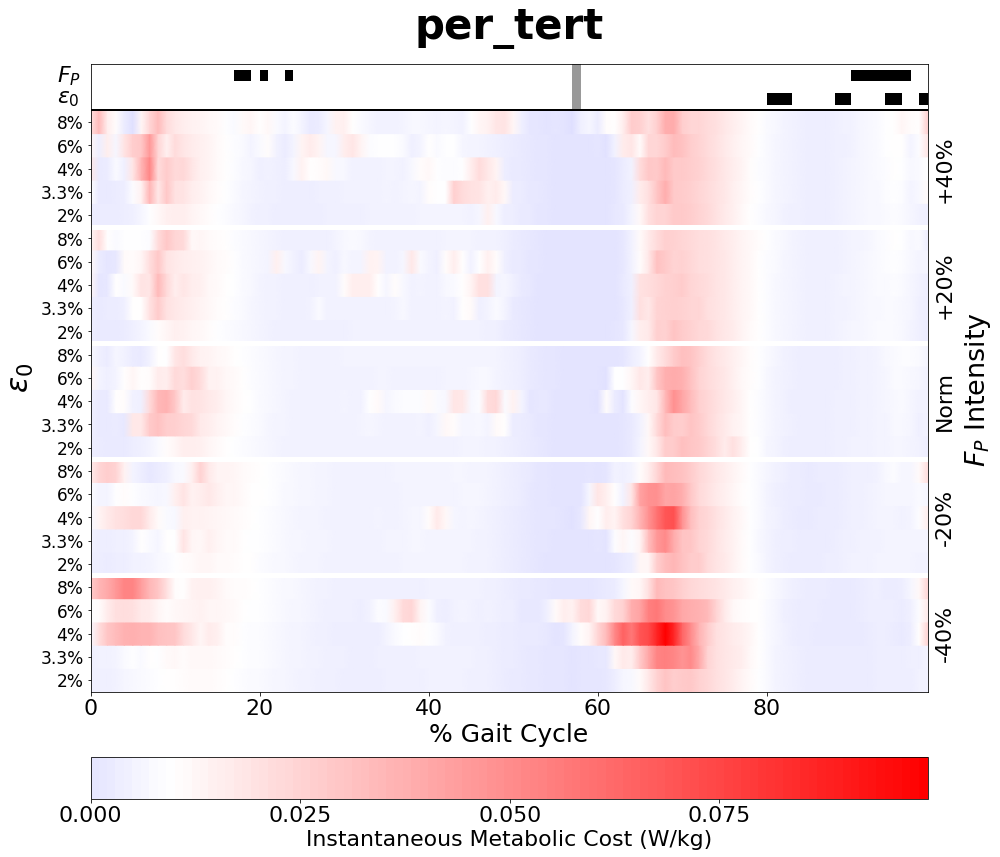

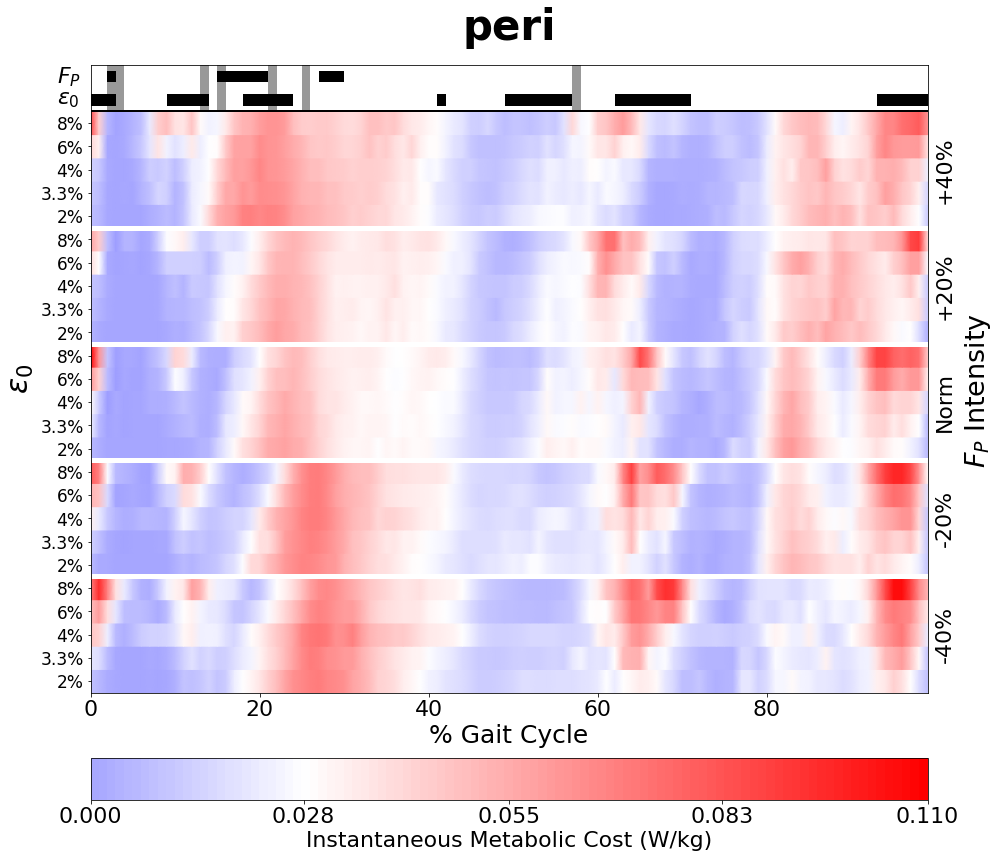

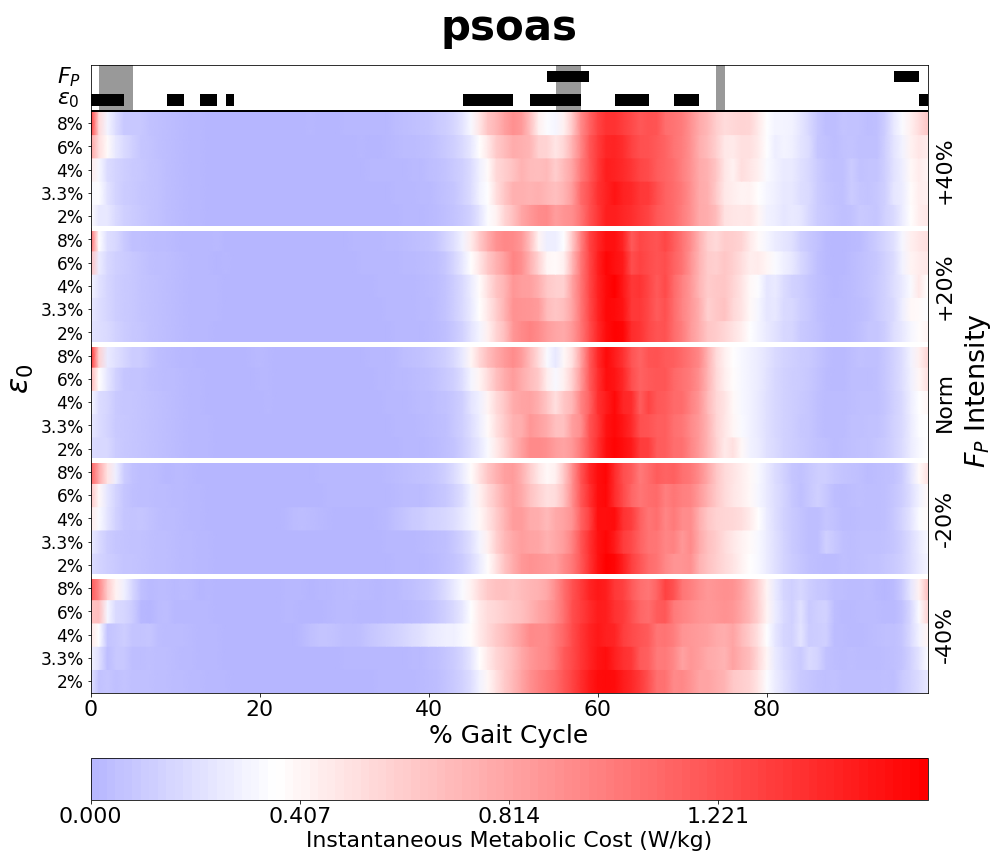

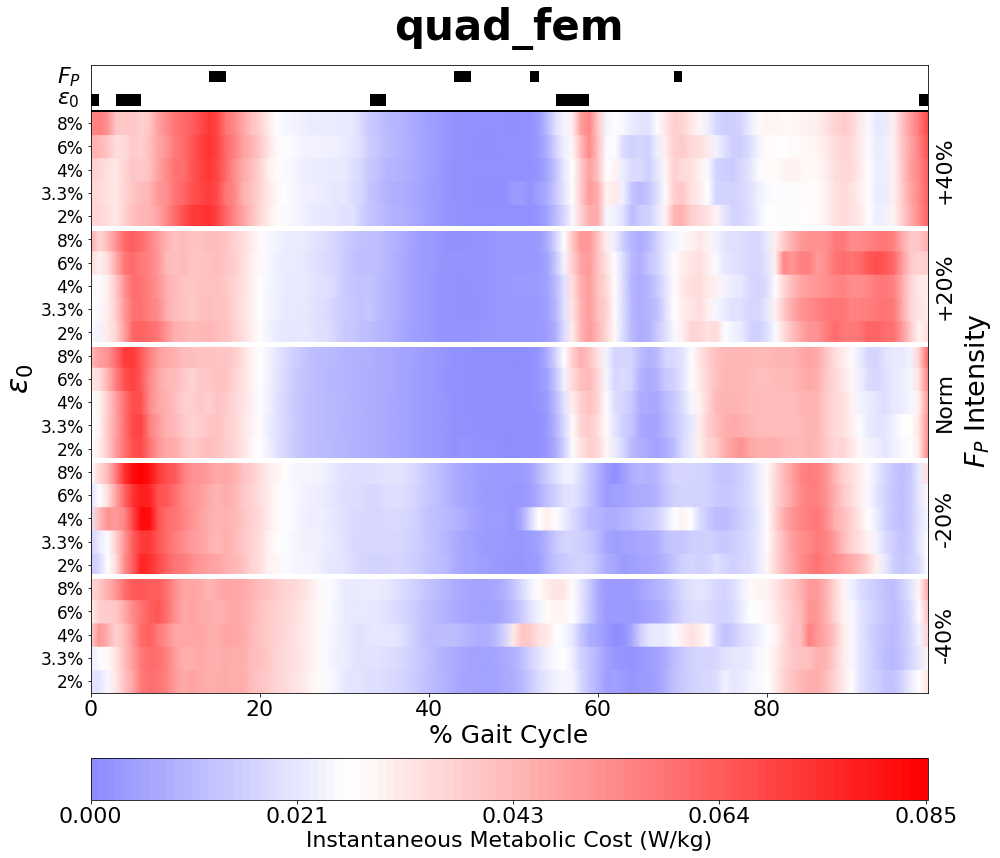

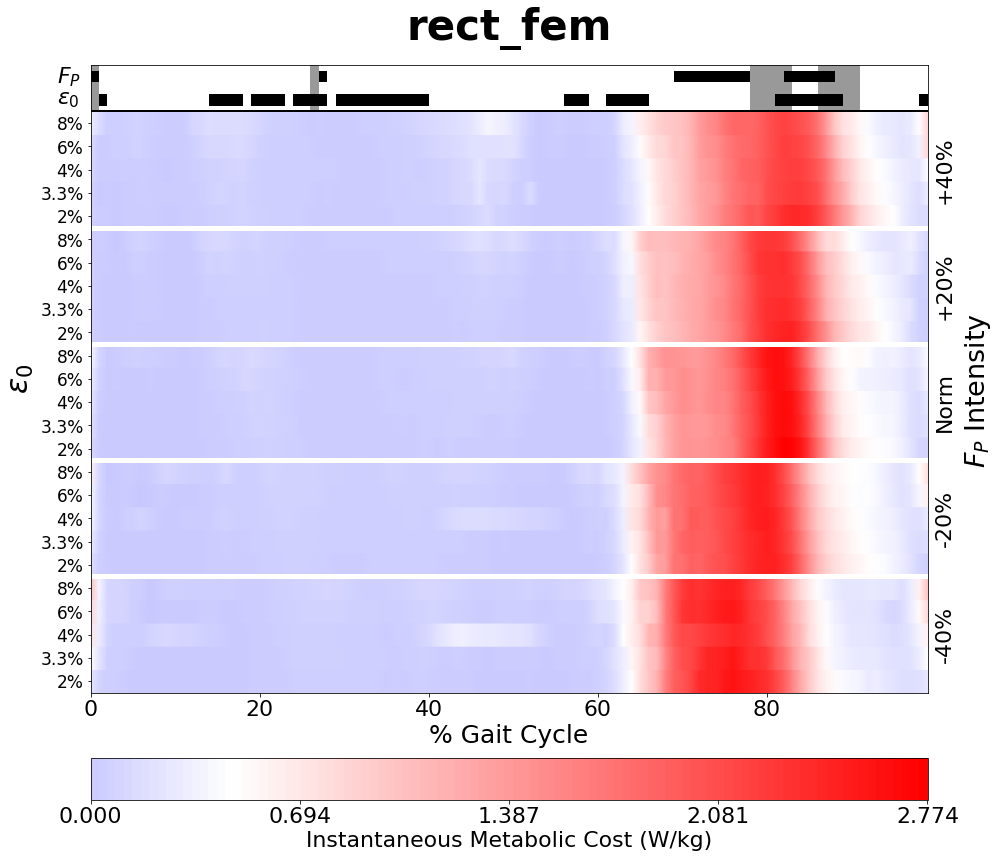

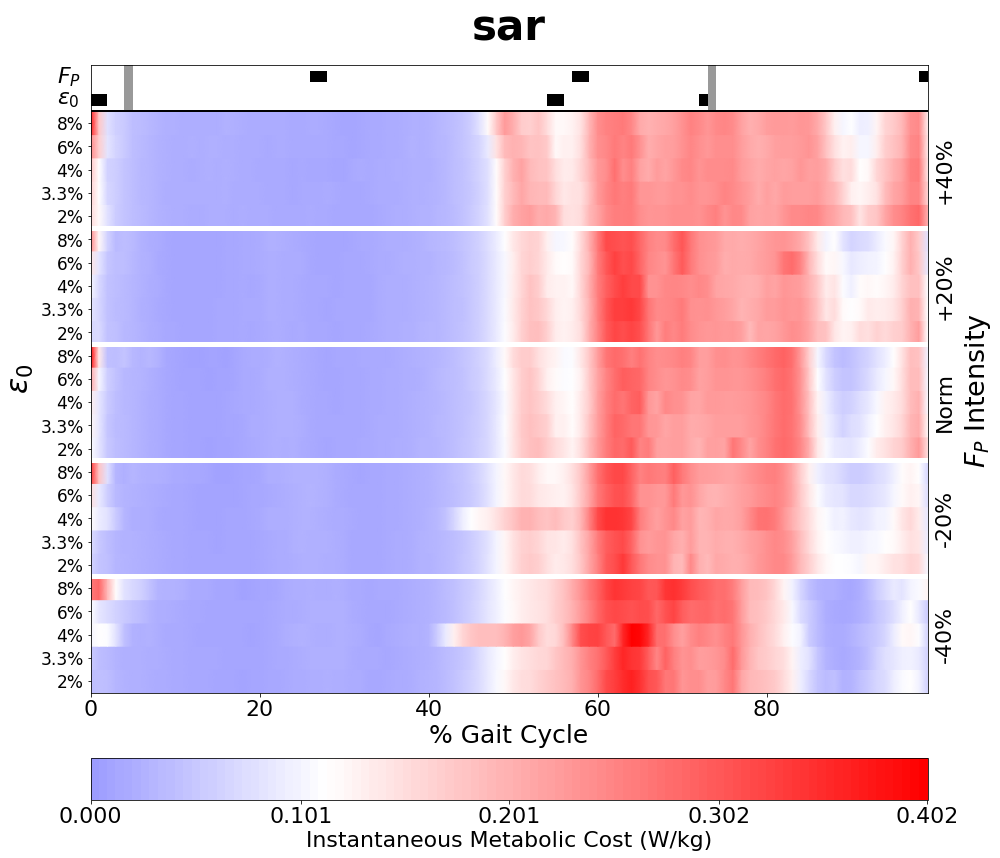

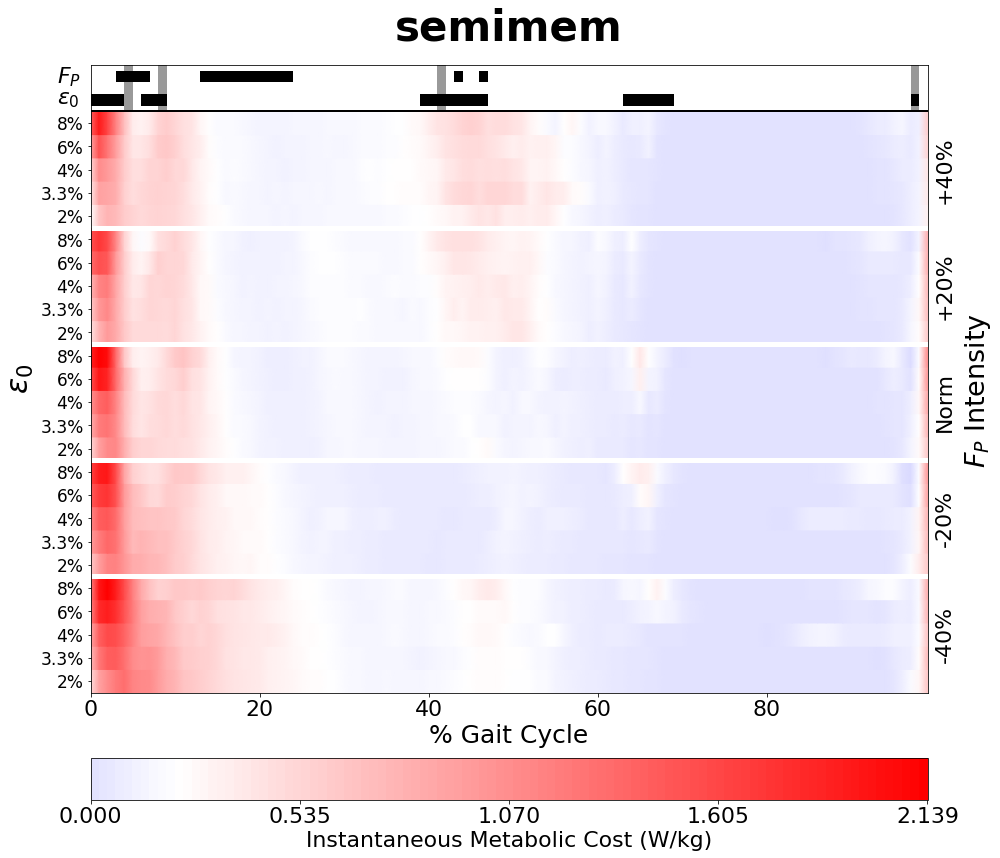

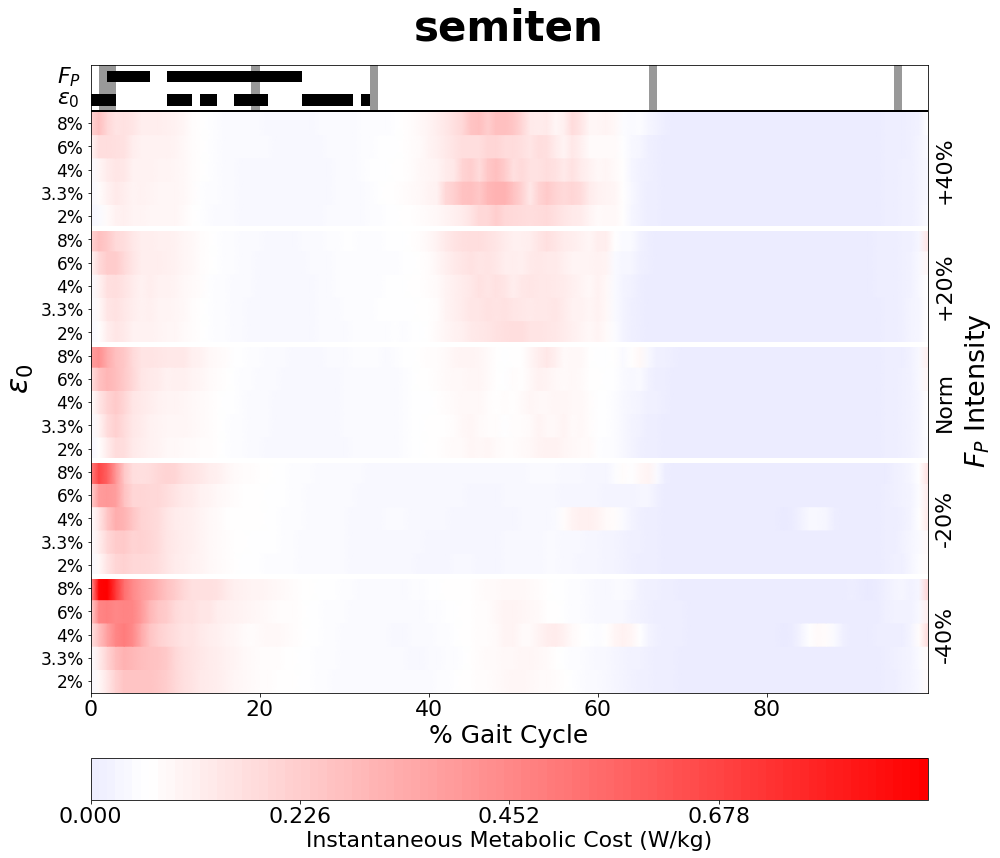

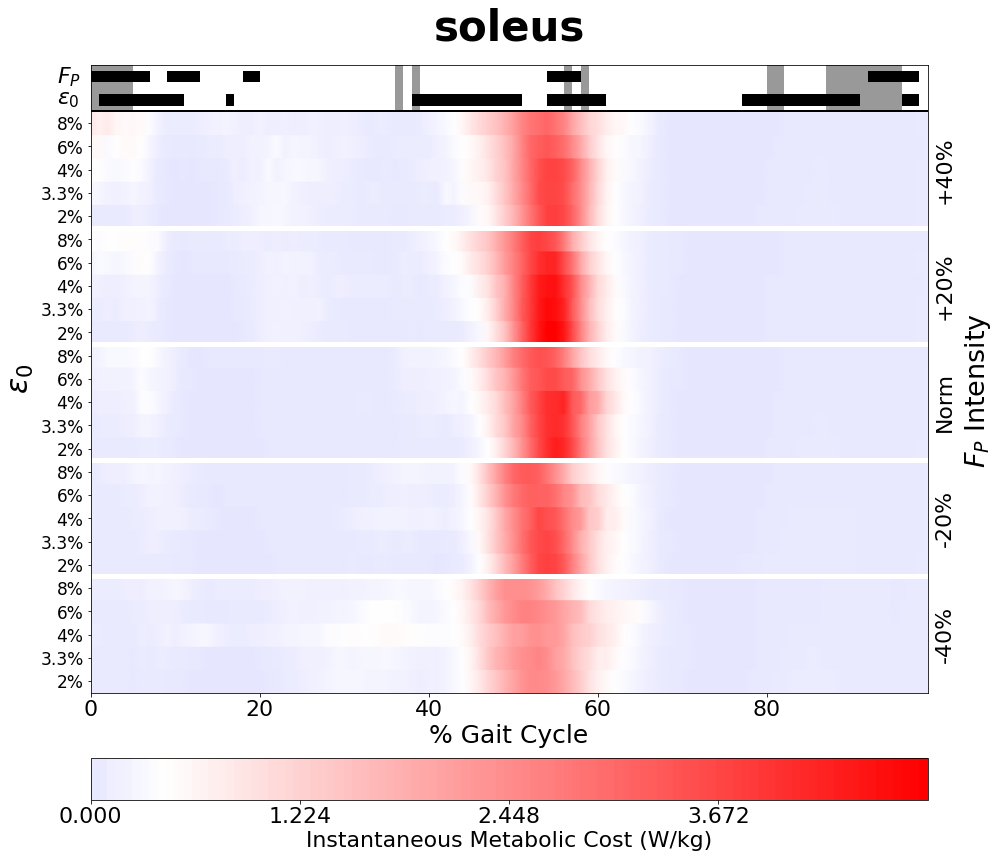

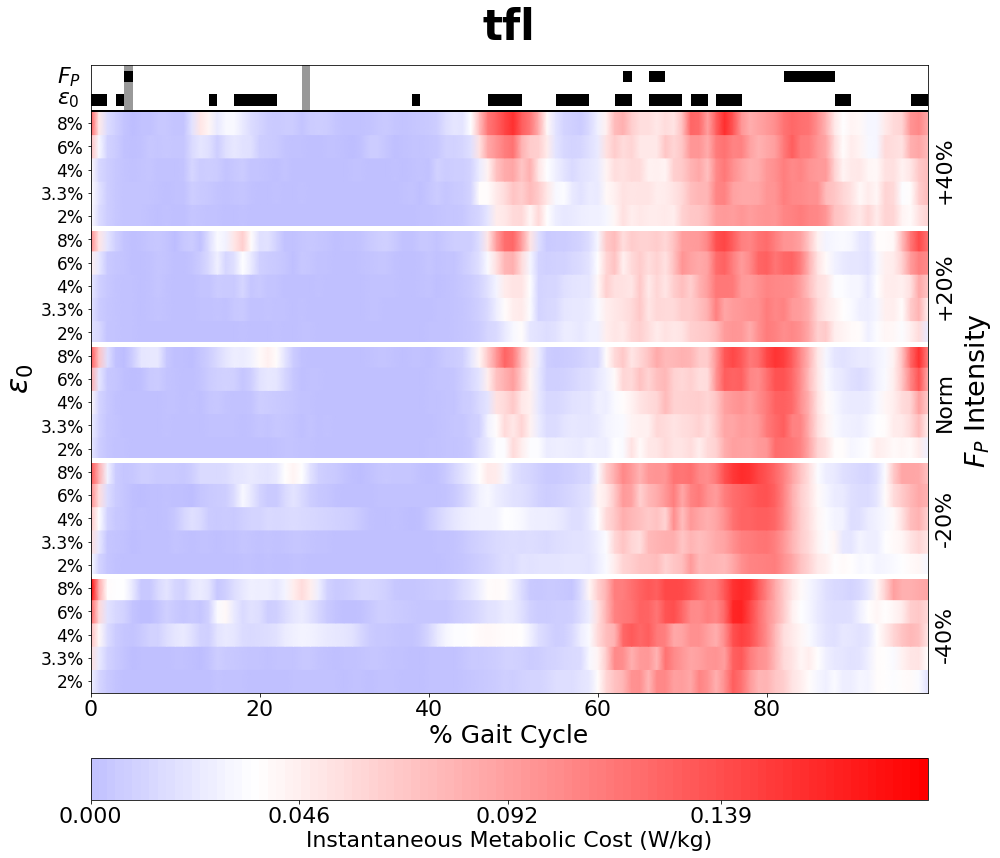

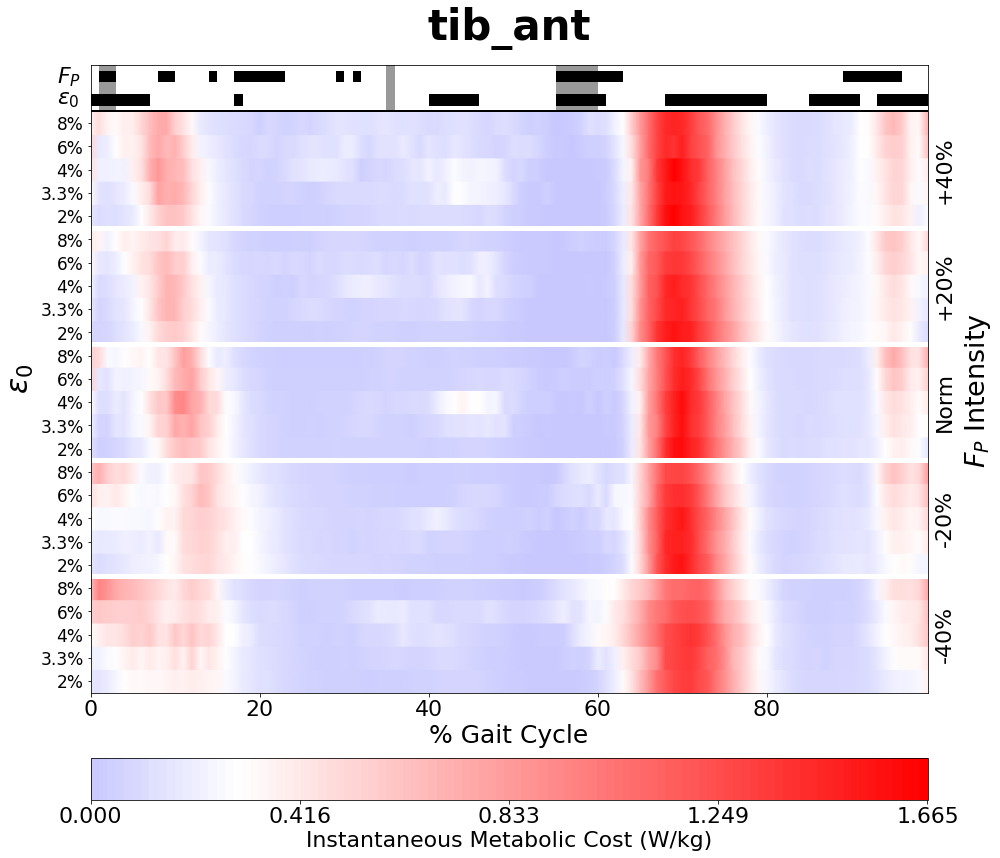

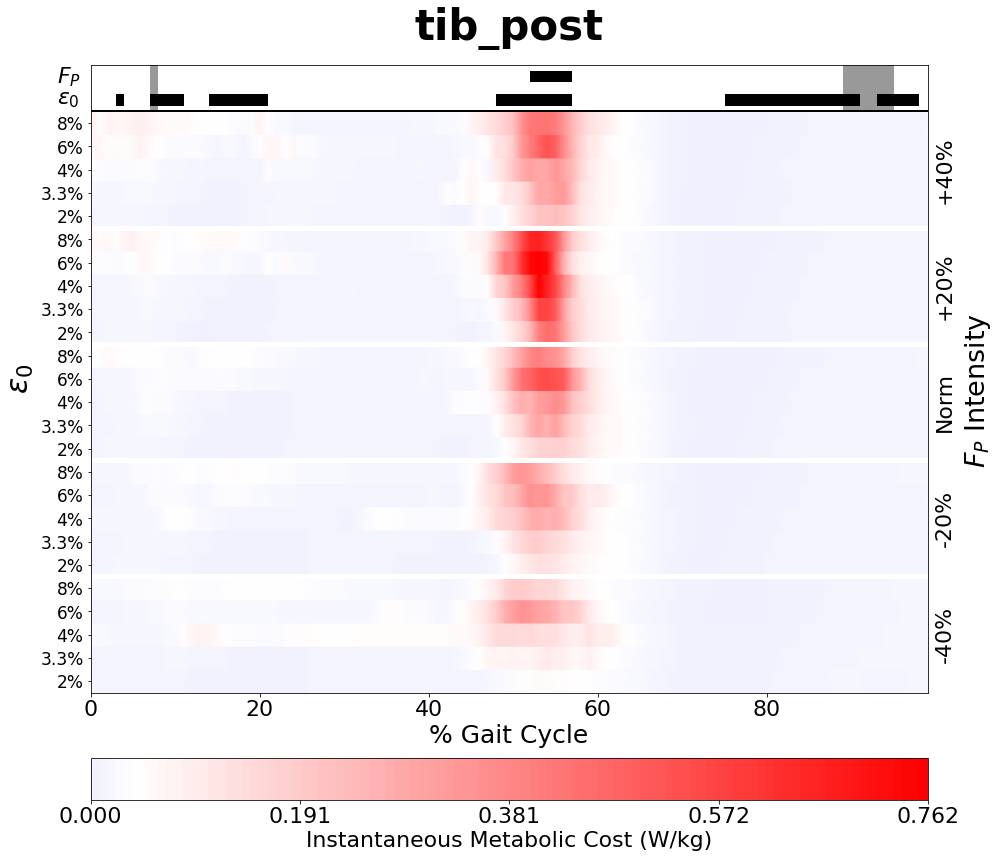

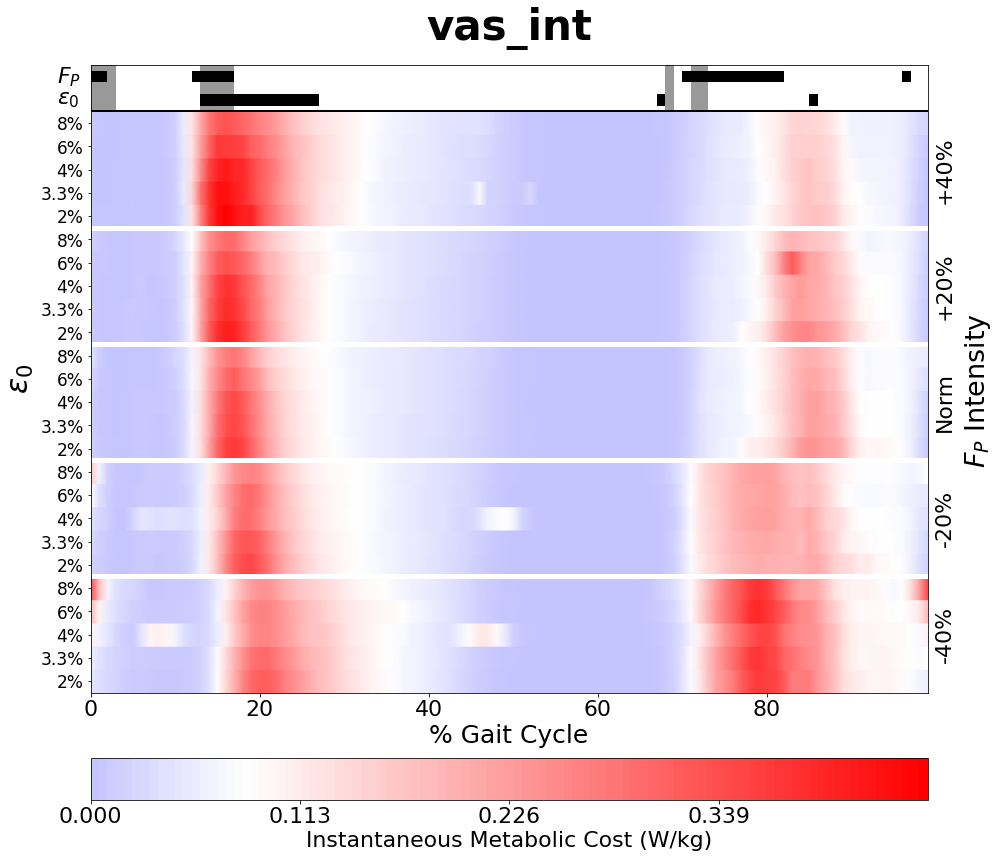

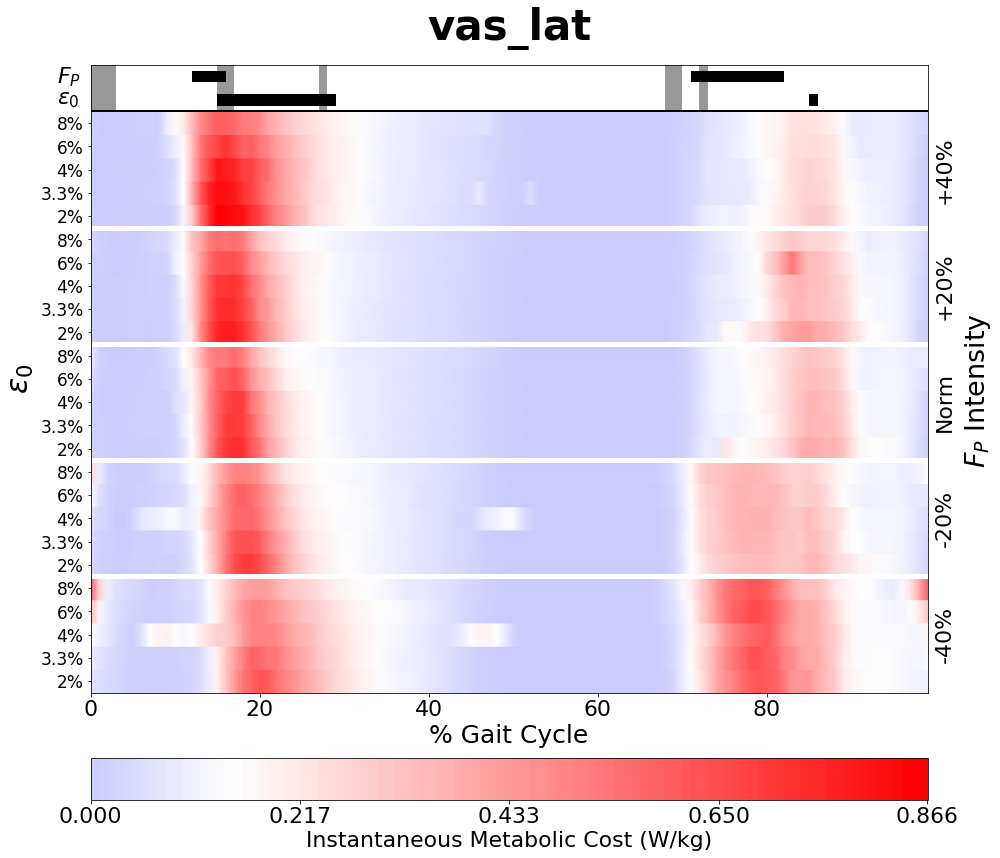

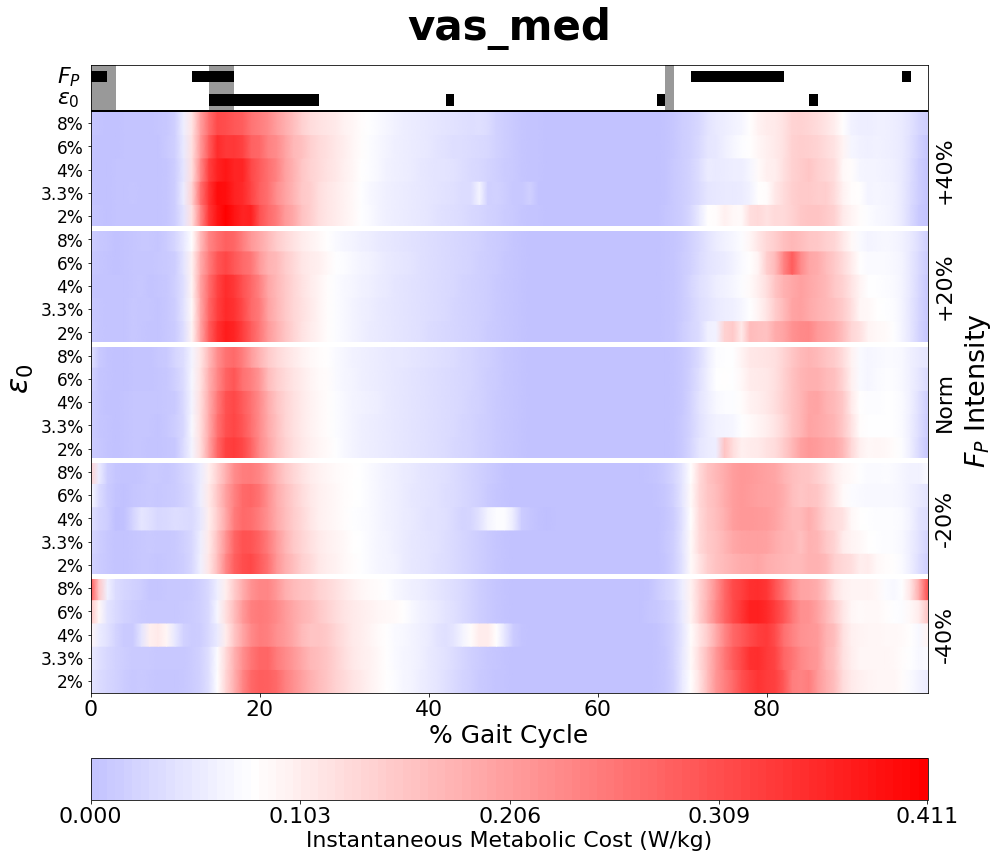

In [13]:
# generate figures for all muscles
Go = 1
if Go == 1:
  AllMuscles = np.unique(MetCost['Muscles'])
  for M in AllMuscles: 
      print(M)
      plotGCHeatMap(M)

## Make Table of Muscle Metabolic Costs 

In [ ]:
# make table of ranked metabolic costs
muscles = np.unique(MetCost['Muscles'])
MuscleData = {}
Strn = 3
StrnInds = [x for x, z in enumerate(MetCost['StrnLvl'].tolist()) if z == Strn]
cond = 'NormF'
CondInds = [x for x, z in enumerate(MetCost['Cond'].tolist()) if z == cond]
match = list(set(CondInds) & set(StrnInds))
Defaults = MetCost.iloc[match, :]
muscles = np.unique(MetCost['Muscles'])

M = {}
M_Avg = {}
M_Tot = {}
TotCost = []
M_Conds = {}
M_Strns = {}
for m in muscles: 
    # muscle average data from default condition and strain level
    MuscInds = [x for x, z in enumerate(Defaults['Muscles'].tolist()) if z == m]
    match = list(set(MuscInds))
    M[m] = Defaults.iloc[match, 5:]
    M_Avg[m] = M[m].mean()
    M_Tot[m] = M_Avg[m].mean()
    TotCost.append(M_Avg[m].mean())

    MuscInds = [x for x, z in enumerate(MetCost['Muscles'].tolist()) if z == m]
    
    # save condition averages
    Conds = ['Fm40','Fm20','NormF','Fp20','Fp40']
    CondVals = []
    for C in Conds: 
        CondInds = [x for x, z in enumerate(MetCost['Cond'].tolist()) if z == C]
        Strn = 3
        StrnInds = [x for x, z in enumerate(MetCost['StrnLvl'].tolist()) if z == Strn]
        match = list(set(CondInds) & set(StrnInds) & set(MuscInds))
        condVals = np.mean(np.array(MetCost.iloc[match, 5:]))#.mean().mean()
        CondVals.append(condVals)
        del condVals, match, StrnInds, CondInds

    M_Conds[m] = CondVals

    # save strain averages
    Strns = [2, 3, 4, 6, 8]
    StrnVals = []
    for S in Strns: 
        StrnInds = [x for x, z in enumerate(MetCost['StrnLvl'].tolist()) if z == S]
        Cond = 'NormF'
        CondInds = [x for x, z in enumerate(MetCost['Cond'].tolist()) if z == Cond]
        match = list(set(CondInds) & set(StrnInds) & set(MuscInds))
        strnVals = MetCost.iloc[match, 5:].mean().mean()
        StrnVals.append(strnVals)
        del strnVals, match, StrnInds, CondInds

    M_Strns[m] = StrnVals


In [ ]:
# Make Table
from scipy.signal import correlate2d
T = pd.DataFrame(columns = ['Muscle','DefCost','%TotalCost','pFp','nFp', 'pKt', 'nKt', 'pInt', 'nInt', 'Fit'])
denom = M_Tot['Total'] # set denominator for relative metabolic cost
TotMap = Map['Total'] # set total map for 2D correlation -> goodness of fit
MaxCorr = correlate2d(TotMap, TotMap, mode='valid')
Cond = 0
StrnLvl = 1
Interaction = 2
for i, m in enumerate(muscles): 
   T.loc[i] = [m, M_Tot[m], round(100*M_Tot[m]/denom, 1),
              RMAnova[m]['p-unc'][Cond], RMAnova[m]['np2'][Cond],
              RMAnova[m]['p-unc'][StrnLvl], RMAnova[m]['np2'][StrnLvl], 
              RMAnova[m]['p-unc'][Interaction], RMAnova[m]['np2'][Interaction], 
              correlate2d(TotMap, Map[m], mode='valid')/MaxCorr]

T.sort_values(by=['DefCost'], ascending=False).reset_index(drop=True).to_csv('RankMuscle.csv')